In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.utils.data
from scipy.io import loadmat
from skimage import io
import spectral

In [2]:
from scipy.io import loadmat, whosmat

# Inspect the contents of the .mat file
mat_contents_img = whosmat(r"C:\Users\ursti\Downloads\GAN\Datasets\PaviaC\Pavia.mat")
mat_contents_gt = whosmat(r"C:\Users\ursti\Downloads\GAN\Datasets\PaviaC\Pavia_gt.mat")

print(mat_contents_img)
print(mat_contents_gt)

[('pavia', (1096, 715, 102), 'double')]
[('pavia_gt', (1096, 715), 'uint8')]


In [3]:
img = loadmat(r"C:\Users\ursti\Downloads\GAN\Datasets\PaviaC\Pavia.mat")['pavia']
gt = loadmat(r"C:\Users\ursti\Downloads\GAN\Datasets\PaviaC\Pavia_gt.mat")['pavia_gt']

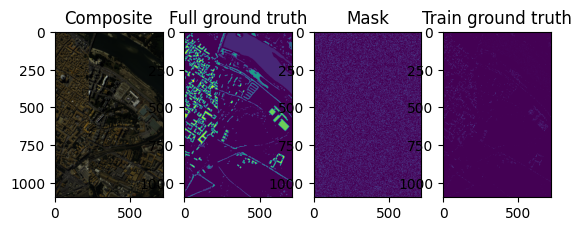

In [4]:
mask = np.random.randint(0, 100, gt.shape) < 5
train_gt = np.copy(gt)
train_gt[np.nonzero(~mask)] = 0
test_gt = np.copy(gt)
test_gt[train_gt > 0] = 0

rgb = img[:,:,(55,41,12)]
rgb = (255 * (rgb.astype(np.float32) - rgb.min())/(rgb.max() - rgb.min())).astype(np.uint8)
fig = plt.figure()
fig.add_subplot(141)
plt.imshow(rgb)
plt.title("Composite")
fig.add_subplot(142)
plt.imshow(gt)
plt.title("Full ground truth")
fig.add_subplot(143)
plt.imshow(mask)
plt.title("Mask")
fig.add_subplot(144)
plt.imshow(train_gt)
plt.title("Train ground truth")
plt.show()

In [5]:
from skimage import morphology

class HyperX(torch.utils.data.Dataset):
    
    def __init__(self, data, ground_truth, semi=False):
        super(HyperX, self).__init__()
        # Normalize the data in [0,1]
        data = (data - data.min()) / (data.max() - data.min())
        self.data = data
        self.gt = ground_truth
        self.n_classes = len(np.unique(ground_truth))
        if semi:
            # Semi-supervision, include neighbours at 50px
            x_pos, y_pos = np.nonzero(morphology.dilation(ground_truth > 0, morphology.disk(50)))
        else:
            x_pos, y_pos = np.nonzero(ground_truth)
        self.indices = [idx for idx in zip(x_pos, y_pos)]
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, i):
        x, y = self.indices[i]
        data = self.data[x,y]
        # Get the label in one-hot encoded style
        label = np.asarray(np.eye(self.n_classes)[self.gt[x, y]], dtype='int64')
        return torch.from_numpy(data), torch.from_numpy(label)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

        
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            nn.Linear(z_dim + c_dim, h_dim),
            nn.SELU(),
            nn.Linear(h_dim, h_dim),
            nn.SELU(),
            nn.Linear(h_dim, h_dim),
            nn.SELU(),
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.SELU(),               # Additional activation
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.SELU(),               # Additional activation
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.SELU(),               # Additional activation
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.SELU(),               # Additional activation
            nn.Linear(h_dim, X_dim),
            nn.Sigmoid()
        )
        self.apply(weight_init)

    def forward(self, z, c):
        inputs = torch.cat([z, c], dim=1)
        return self.generator(inputs)
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            nn.Linear(X_dim, h_dim),
            nn.ELU(),
            nn.Linear(h_dim, h_dim),
            nn.ELU(),
            nn.Linear(h_dim, h_dim),
            nn.ELU(),
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.ELU(),                # Additional activation
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.ELU(),                # Additional activation
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.ELU(),                # Additional activation
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.ELU(),                # Additional activation
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.ELU(),                # Additional activation
            nn.Linear(h_dim, 1)
        )
        self.apply(weight_init)

    def forward(self, x):
        return self.discriminator(x)
    
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(X_dim, h_dim),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(h_dim, h_dim),
            nn.ELU(),
            nn.BatchNorm1d(h_dim),
            nn.Linear(h_dim, h_dim),
            nn.ELU(),
            nn.Dropout(0.5),
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.ELU(),                # Additional activation
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.ELU(),                # Additional activation
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.ELU(),                # Additional activation
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.ELU(),                # Additional activation
            nn.Linear(h_dim, h_dim),  # Additional layer
            nn.ELU(),                # Additional activation
            nn.Linear(h_dim, c_dim)
        )
        self.apply(weight_init)

    def forward(self, x):
        return self.classifier(x)


In [7]:
mb_size = 256 # Batch size
z_dim = 30   # Noise dimension
X_dim = img.shape[-1] # Number of bands
h_dim = 512  # Hidden layer size
d_step = 5   # Number of discriminator training steps for each generator training step
lr = 5e-5    # Learning rate
c_weight = 0.2 # Auxiliary classifier weight
flip_percentage = 0.0 # Proportion of label flipping
mixup_alpha = 0.1 # Mixup
semi_supervised = True # semi-supervision (set to True to include unlabeled samples)

# Build the dataset and data loader
data_loader = torch.utils.data.DataLoader(
    HyperX(img, train_gt if semi_supervised else gt), batch_size=mb_size, shuffle=True)
# c_dim = condition vector size
c_dim = data_loader.dataset.n_classes

# Ignore the class 0
class_weights = torch.ones((c_dim))
class_weights[0] = 0.
class_weights = class_weights.cuda()

In [8]:
# Initialize weights using the He et al. (2015) policy.
def weight_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d, nn.Conv3d, nn.ConvTranspose3d)):
        torch.nn.init.kaiming_normal_(m.weight.data)

# Spherical interpolation between two vectors on the unit hypersphere
# See : https://github.com/soumith/dcgan.torch/issues/14
def slerp(val, low, high):
    omega = np.arccos(np.clip(np.dot(low/np.linalg.norm(low), high/np.linalg.norm(high)), -1, 1))
    so = np.sin(omega)
    if so == 0:
        return (1.0-val) * low + val * high # L'Hopital's rule/LERP
    return np.sin((1.0-val)*omega) / so * low + np.sin(val*omega) / so * high

def lerp(val, low, high):
    return (1.0-val) * low + val * high # L'Hopital's rule/LERP

# Gradient penalty from the Improved WGAN training
# From : https://github.com/EmilienDupont/wgan-gp
# Use penalty_weight set at 10, as suggested in the paper
def calc_gradient_penalty(netD, real_data, generated_data, penalty_weight=10):
        batch_size = real_data.size()[0]

        alpha = torch.rand(batch_size, 1) if real_data.dim() == 2 else torch.rand(batch_size, 1, 1, 1)
        alpha = alpha.expand_as(real_data)
        alpha = alpha.cuda()
        
        interpolated = alpha * real_data + (1 - alpha) * generated_data
        #interpolated = Variable(interpolated, requires_grad=True)
        interpolated.requires_grad_()
        interpolated = interpolated.cuda()

        # Calculate probability of interpolated examples
        prob_interpolated = netD(interpolated)

        # Calculate gradients of probabilities with respect to examples
        gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                               grad_outputs=torch.ones(prob_interpolated.size()).cuda(),
                               create_graph=True, retain_graph=True)[0]

        # Gradients have shape (batch_size, num_channels, img_width, img_height),
        # so flatten to easily take norm per example in batch
        gradients = gradients.view(batch_size, -1)

        # Derivatives of the gradient close to 0 can cause problems because of
        # the square root, so manually calculate norm and add epsilon
        gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)

        # Return gradient penalty
        return penalty_weight * ((gradients_norm - 1) ** 2).mean()
    
def reset_grad(*nets):
    for net in nets:
        net.zero_grad()
        
def plot_mean_std(samples):
    mean_spectrum = np.mean(samples, axis=0)
    std_spectrum = np.std(samples, axis=0)
    plt.plot(mean_spectrum - std_spectrum, linestyle='dotted', label='-std')
    plt.plot(mean_spectrum, label='mean')
    plt.plot(mean_spectrum + std_spectrum, linestyle='dotted', label='+std')

  0%|                                                                                       | 0/100000 [00:00<?, ?it/s]C:\Users\ursti\AppData\Local\Temp\ipykernel_24180\1864507184.py:65: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  pred = F.log_softmax(C(X))


Iter-0; D_loss: 0.713630199432373; G_loss: 2.0942862033843994; C_loss: 3.2836406230926514


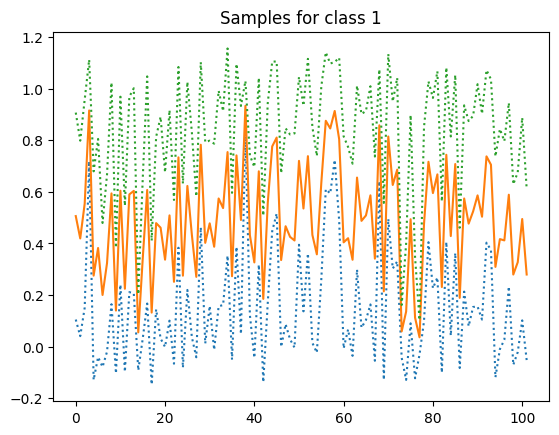

  1%|▋                                                                        | 1000/100000 [05:40<10:57:29,  2.51it/s]

Iter-1000; D_loss: -0.03768923506140709; G_loss: -1.0514696836471558; C_loss: 0.23669946193695068


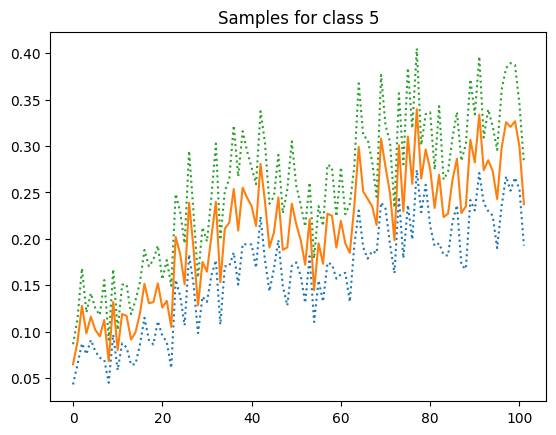

  2%|█▍                                                                        | 2000/100000 [11:11<8:22:41,  3.25it/s]

Iter-2000; D_loss: 0.16469791531562805; G_loss: -1.7115999460220337; C_loss: 0.1136920303106308


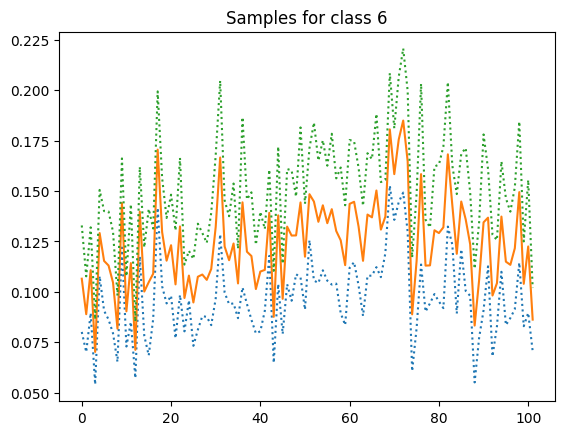

  3%|██▏                                                                       | 3000/100000 [16:39<8:24:24,  3.21it/s]

Iter-3000; D_loss: 0.018428917974233627; G_loss: -1.6295090913772583; C_loss: 0.11225983500480652


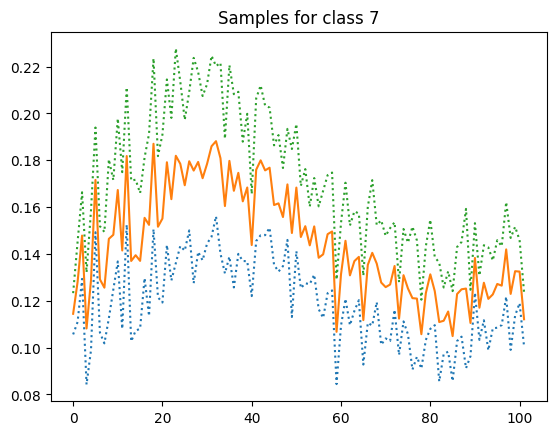

  4%|██▉                                                                       | 4000/100000 [22:10<8:48:53,  3.03it/s]

Iter-4000; D_loss: -0.022124547511339188; G_loss: -0.6315750479698181; C_loss: 0.021976783871650696


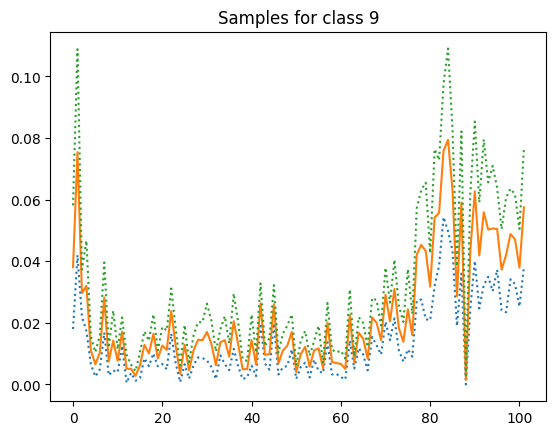

  5%|███▋                                                                      | 5000/100000 [27:43<8:17:13,  3.18it/s]

Iter-5000; D_loss: -0.04595817252993584; G_loss: -0.23550450801849365; C_loss: 0.03705412894487381


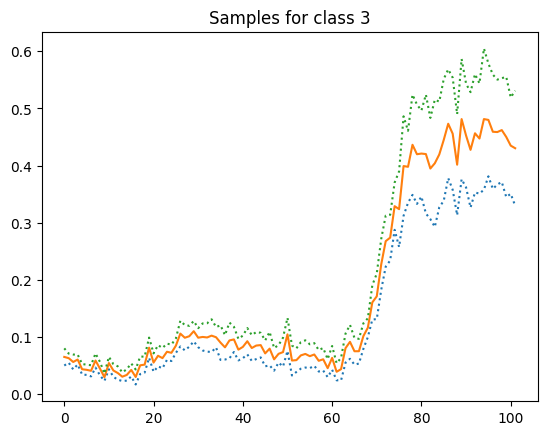

  6%|████▍                                                                     | 6000/100000 [33:17<8:34:04,  3.05it/s]

Iter-6000; D_loss: -0.008829740807414055; G_loss: -0.5791249871253967; C_loss: 0.029227474704384804


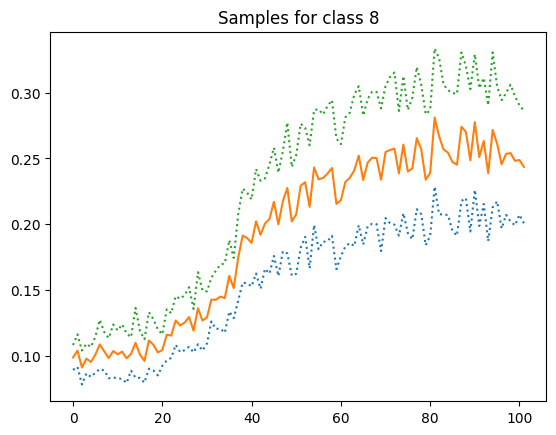

  7%|█████▏                                                                    | 7000/100000 [39:01<8:49:57,  2.92it/s]

Iter-7000; D_loss: 0.06207607686519623; G_loss: -0.9675438404083252; C_loss: 0.01830098032951355


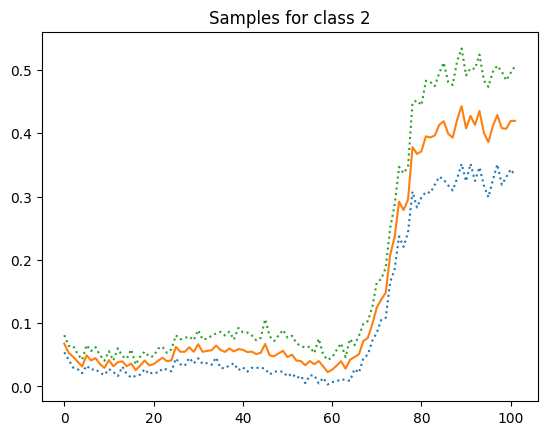

  8%|█████▉                                                                    | 8000/100000 [44:46<9:04:43,  2.81it/s]

Iter-8000; D_loss: 0.06323973089456558; G_loss: -0.8942034244537354; C_loss: 0.030939389020204544


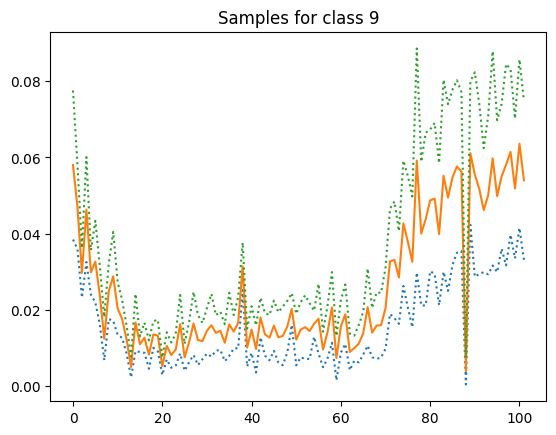

  9%|██████▋                                                                   | 9000/100000 [50:24<8:53:11,  2.84it/s]

Iter-9000; D_loss: 0.02880050241947174; G_loss: -1.0082530975341797; C_loss: 0.04139171913266182


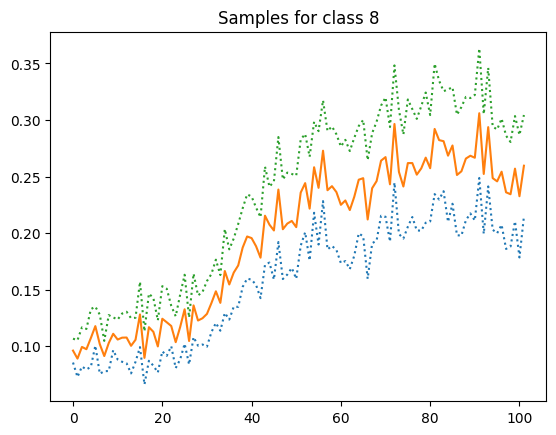

 10%|███████▎                                                                 | 10000/100000 [56:01<8:39:58,  2.88it/s]

Iter-10000; D_loss: -0.0009866426698863506; G_loss: -1.0110174417495728; C_loss: 0.03869504854083061


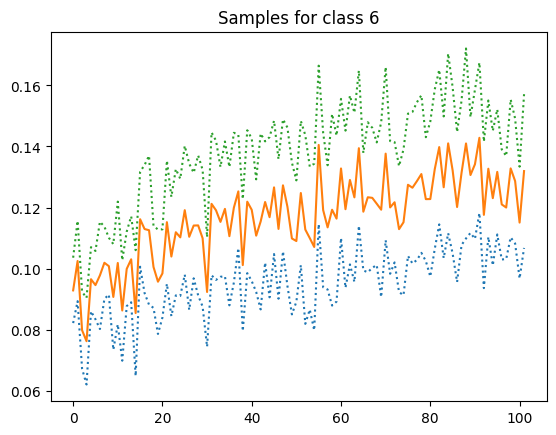

 11%|███████▊                                                               | 11000/100000 [1:01:36<8:32:36,  2.89it/s]

Iter-11000; D_loss: 0.012977080419659615; G_loss: -0.7958208918571472; C_loss: 0.024412909522652626


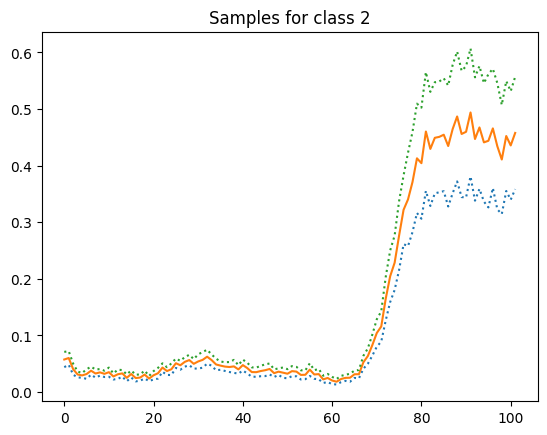

 12%|████████▌                                                              | 12000/100000 [1:07:17<8:48:05,  2.78it/s]

Iter-12000; D_loss: 0.00846182182431221; G_loss: -0.693036675453186; C_loss: 0.01768556982278824


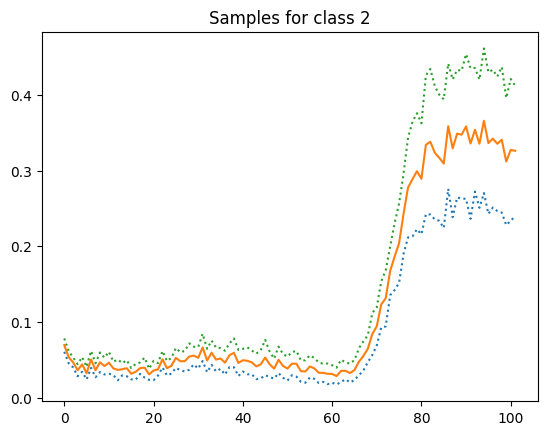

 13%|█████████▏                                                             | 13000/100000 [1:12:52<7:51:02,  3.08it/s]

Iter-13000; D_loss: 0.004763726145029068; G_loss: -0.3255613446235657; C_loss: 0.01518337894231081


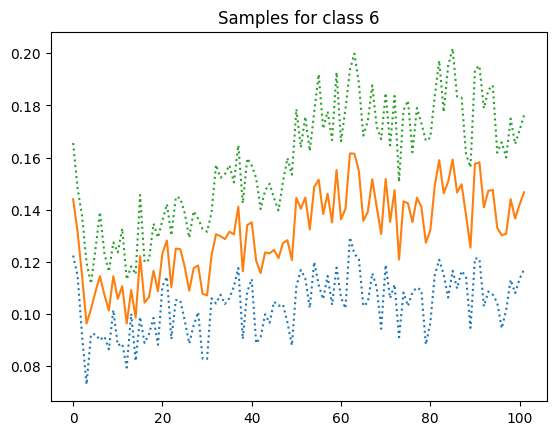

 14%|█████████▉                                                             | 14000/100000 [1:18:30<7:48:03,  3.06it/s]

Iter-14000; D_loss: -0.011792046017944813; G_loss: -0.3476884663105011; C_loss: 0.031007928773760796


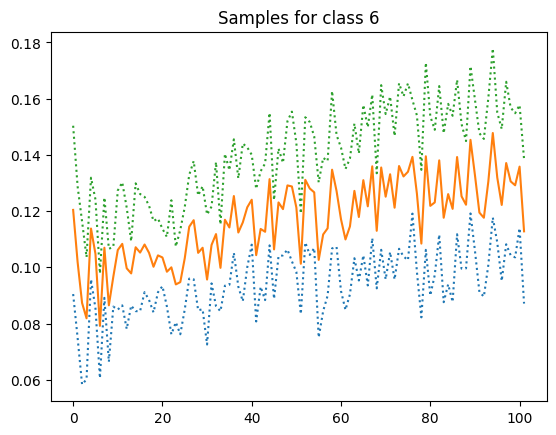

 15%|██████████▋                                                            | 15000/100000 [1:24:10<8:15:39,  2.86it/s]

Iter-15000; D_loss: -0.015824059024453163; G_loss: -0.5704163312911987; C_loss: 0.06441154330968857


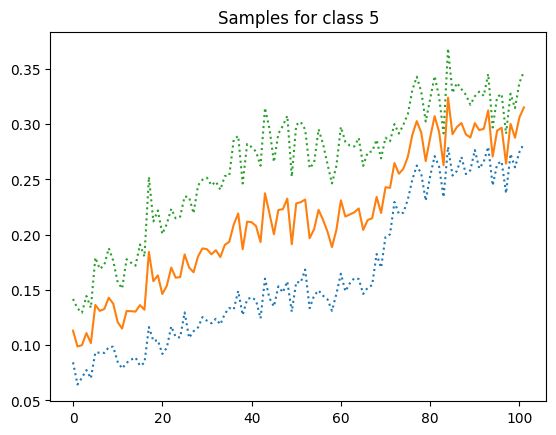

 16%|███████████▎                                                           | 16000/100000 [1:29:46<7:38:46,  3.05it/s]

Iter-16000; D_loss: -0.02406502142548561; G_loss: -0.5069820284843445; C_loss: 0.04620330408215523


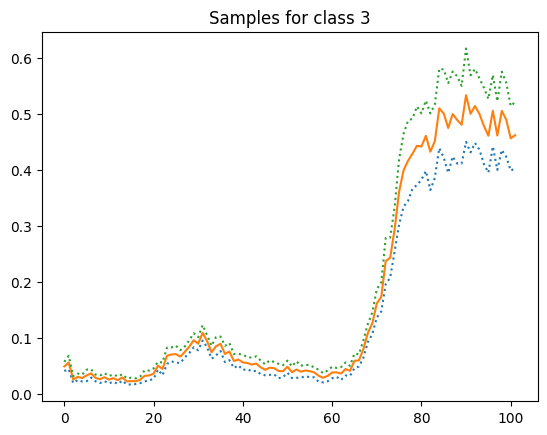

 17%|████████████                                                           | 17000/100000 [1:35:21<8:20:55,  2.76it/s]

Iter-17000; D_loss: 0.005310834385454655; G_loss: -0.16188886761665344; C_loss: 0.016061844304203987


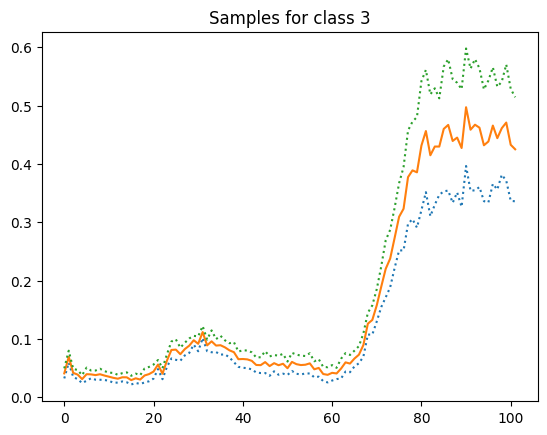

 18%|████████████▊                                                          | 18000/100000 [1:40:56<7:35:18,  3.00it/s]

Iter-18000; D_loss: 0.002452302724123001; G_loss: -0.07357406616210938; C_loss: 0.09273672103881836


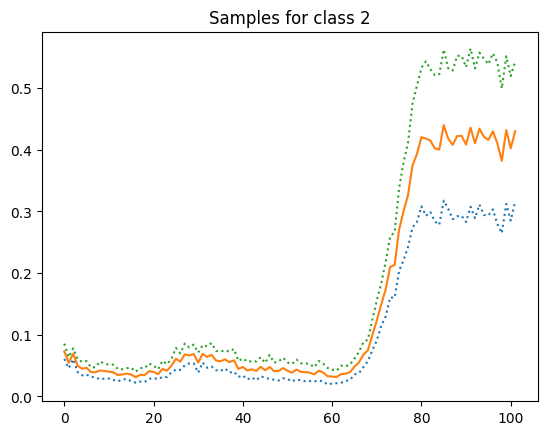

 19%|█████████████▍                                                         | 19000/100000 [1:46:32<7:29:04,  3.01it/s]

Iter-19000; D_loss: 0.029980774968862534; G_loss: -0.5248134136199951; C_loss: 0.016185620799660683


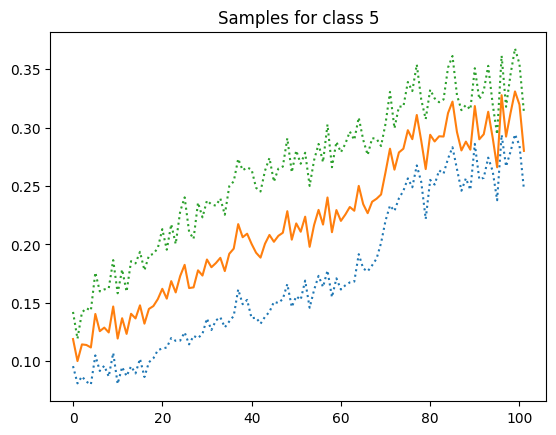

 20%|██████████████▏                                                        | 20000/100000 [1:52:08<6:58:19,  3.19it/s]

Iter-20000; D_loss: 0.010157942771911621; G_loss: -0.4423665404319763; C_loss: 0.01389146689325571


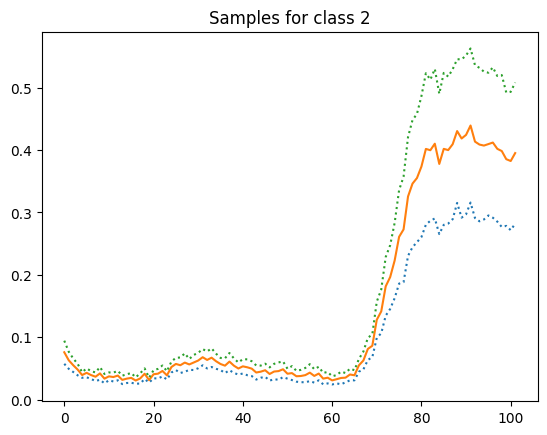

 21%|██████████████▉                                                        | 21000/100000 [1:57:47<7:33:08,  2.91it/s]

Iter-21000; D_loss: -0.024557771161198616; G_loss: -0.6473523378372192; C_loss: 0.016547471284866333


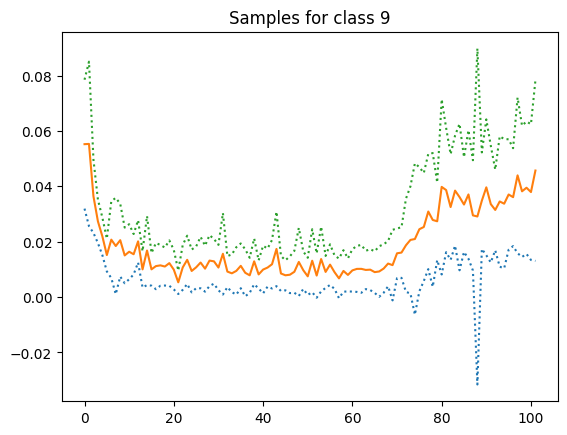

 22%|███████████████▌                                                       | 22000/100000 [2:02:44<4:01:37,  5.38it/s]

Iter-22000; D_loss: -0.010025981813669205; G_loss: -1.0646686553955078; C_loss: 0.00840832944959402


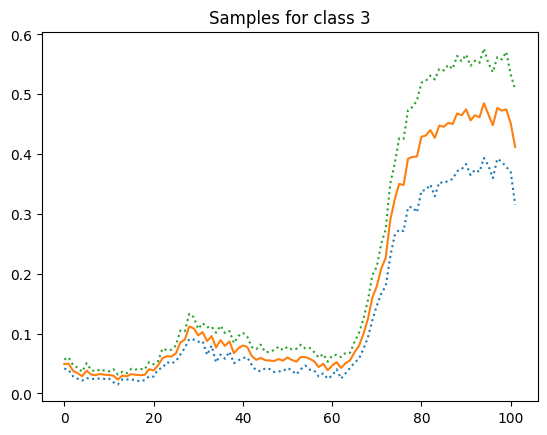

 23%|████████████████▎                                                      | 23000/100000 [2:05:50<3:53:01,  5.51it/s]

Iter-23000; D_loss: -0.02948889508843422; G_loss: -0.5412847995758057; C_loss: 0.03655194118618965


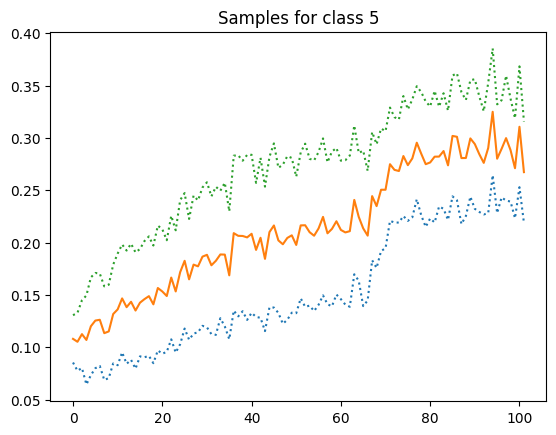

 24%|█████████████████                                                      | 24000/100000 [2:08:57<3:39:49,  5.76it/s]

Iter-24000; D_loss: -0.018831800669431686; G_loss: -1.3765428066253662; C_loss: 0.05621309205889702


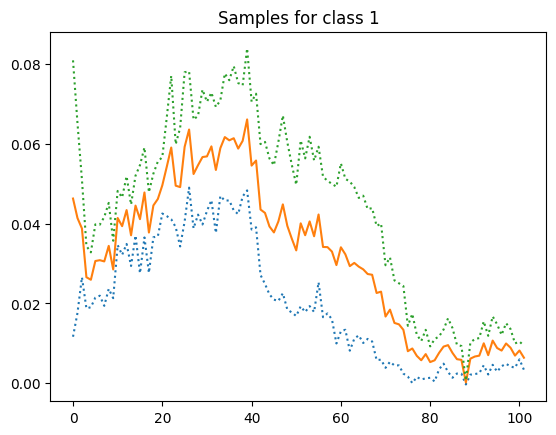

 25%|█████████████████▊                                                     | 25000/100000 [2:12:04<3:43:57,  5.58it/s]

Iter-25000; D_loss: 0.05116765946149826; G_loss: -1.13409423828125; C_loss: 0.013135145418345928


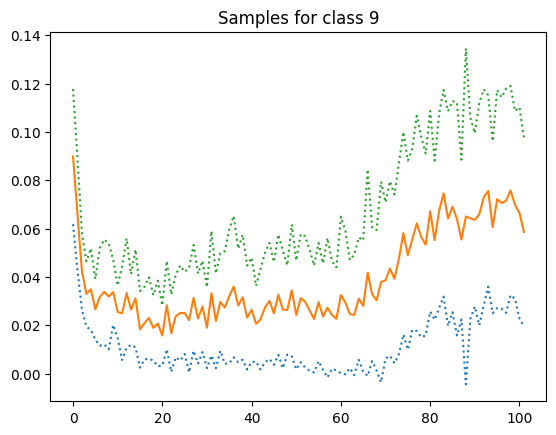

 26%|██████████████████▍                                                    | 26000/100000 [2:15:09<4:03:07,  5.07it/s]

Iter-26000; D_loss: -0.00793786533176899; G_loss: -1.3666203022003174; C_loss: 0.06422717869281769


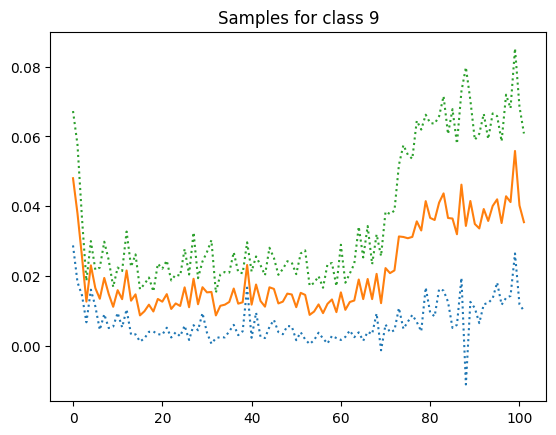

 27%|███████████████████▏                                                   | 27000/100000 [2:18:13<3:33:51,  5.69it/s]

Iter-27000; D_loss: 0.026232322677969933; G_loss: -1.1737215518951416; C_loss: 0.01550967711955309


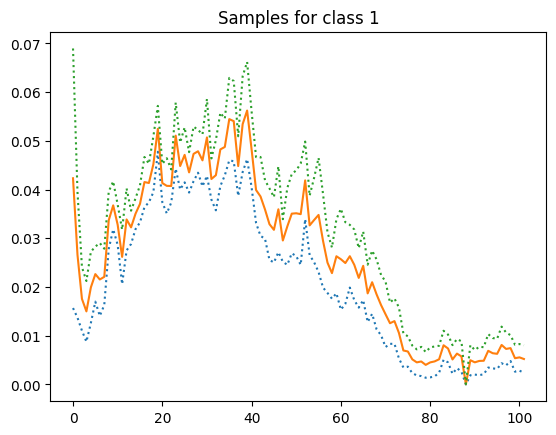

 28%|███████████████████▉                                                   | 28000/100000 [2:21:28<3:40:25,  5.44it/s]

Iter-28000; D_loss: 0.02302955463528633; G_loss: -0.9675948619842529; C_loss: 0.007791681680828333


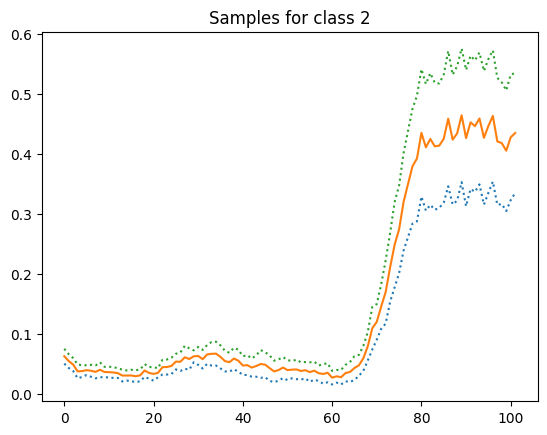

 29%|████████████████████▌                                                  | 29000/100000 [2:24:36<3:13:07,  6.13it/s]

Iter-29000; D_loss: 0.01243034191429615; G_loss: -0.7709132432937622; C_loss: 0.055215299129486084


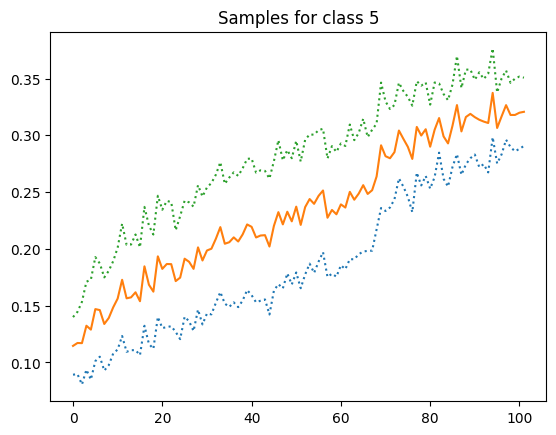

 30%|█████████████████████▎                                                 | 30000/100000 [2:27:39<3:42:54,  5.23it/s]

Iter-30000; D_loss: 0.0052926065400242805; G_loss: -0.6803895235061646; C_loss: 0.02790512703359127


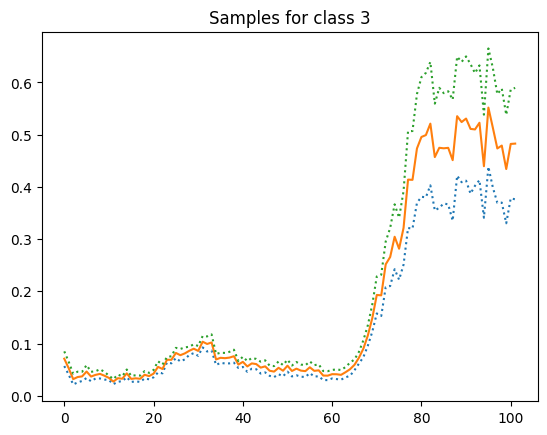

 31%|██████████████████████                                                 | 31000/100000 [2:30:42<3:33:10,  5.39it/s]

Iter-31000; D_loss: -0.0008871210739016533; G_loss: -0.6708596348762512; C_loss: 0.008876132778823376


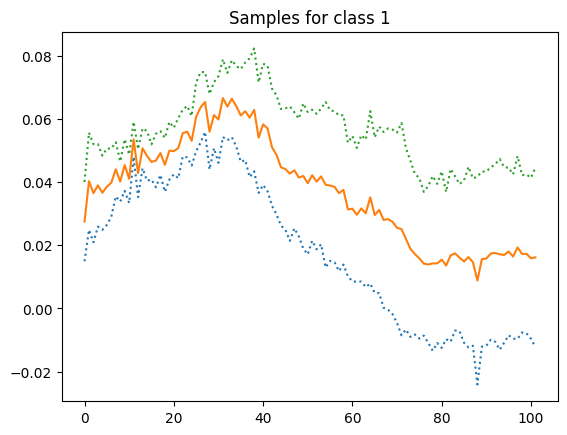

 32%|██████████████████████▋                                                | 32000/100000 [2:33:47<3:44:23,  5.05it/s]

Iter-32000; D_loss: 0.025040239095687866; G_loss: -0.5801005363464355; C_loss: 0.06778210401535034


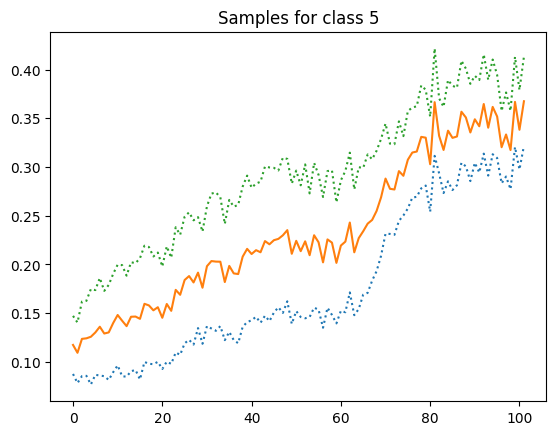

 33%|███████████████████████▍                                               | 33000/100000 [2:36:50<3:16:17,  5.69it/s]

Iter-33000; D_loss: 0.01624481938779354; G_loss: -0.28074562549591064; C_loss: 0.02820088341832161


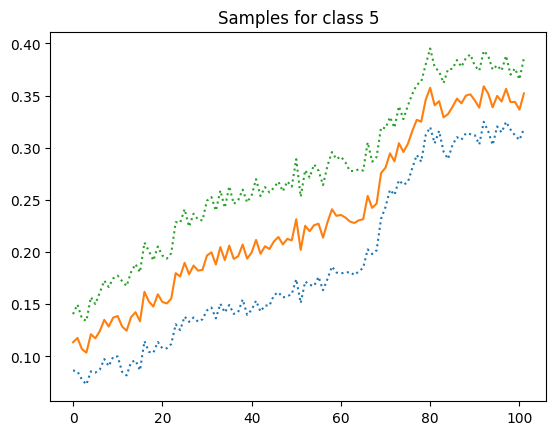

 34%|████████████████████████▏                                              | 34000/100000 [2:39:57<3:36:09,  5.09it/s]

Iter-34000; D_loss: 0.010177604854106903; G_loss: -0.09567078948020935; C_loss: 0.030162742361426353


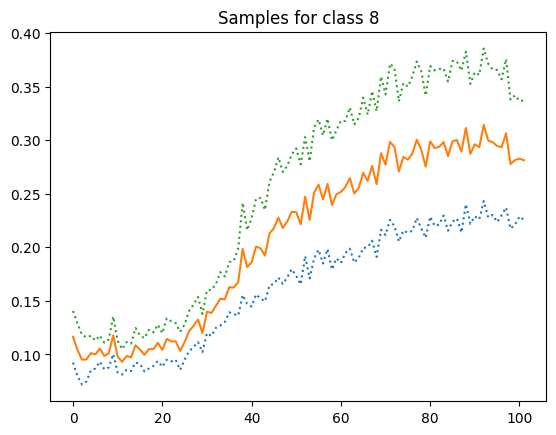

 35%|████████████████████████▊                                              | 35000/100000 [2:43:01<3:29:51,  5.16it/s]

Iter-35000; D_loss: 7.59633257985115e-05; G_loss: 0.16774147748947144; C_loss: 0.018754461780190468


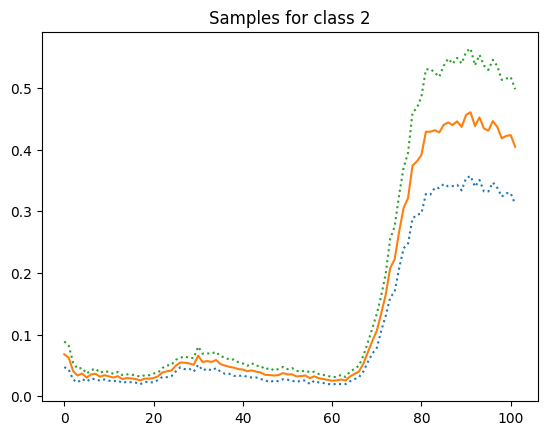

 36%|█████████████████████████▌                                             | 36000/100000 [2:46:05<3:26:27,  5.17it/s]

Iter-36000; D_loss: -0.0253360066562891; G_loss: -0.21581211686134338; C_loss: 0.02197546698153019


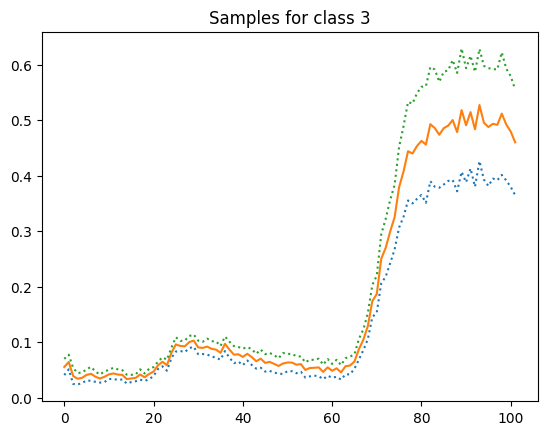

 37%|██████████████████████████▎                                            | 37000/100000 [2:49:09<3:14:27,  5.40it/s]

Iter-37000; D_loss: -0.012803100049495697; G_loss: -0.31818482279777527; C_loss: 0.047209881246089935


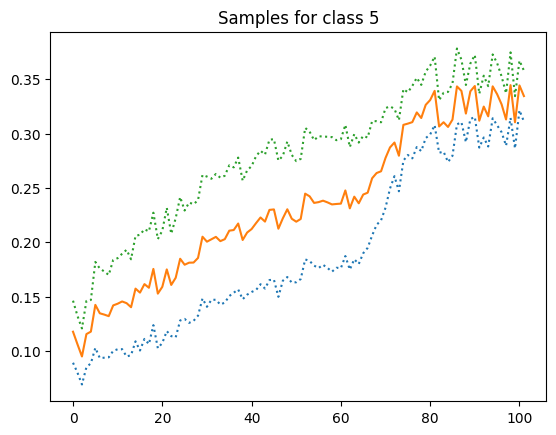

 38%|██████████████████████████▉                                            | 38000/100000 [2:52:14<3:03:09,  5.64it/s]

Iter-38000; D_loss: -0.014880230650305748; G_loss: -0.17755058407783508; C_loss: 0.019785385578870773


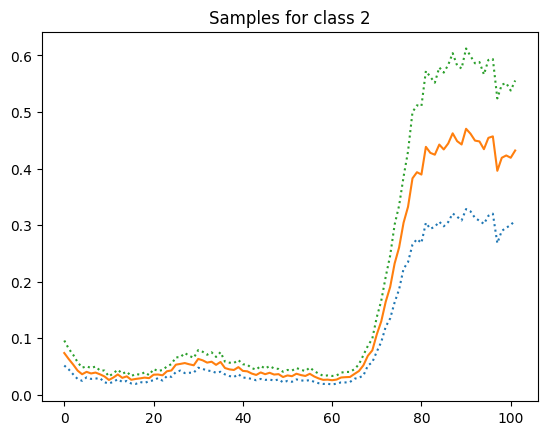

 39%|███████████████████████████▋                                           | 39000/100000 [2:55:47<5:18:24,  3.19it/s]

Iter-39000; D_loss: -0.013553135097026825; G_loss: -0.3876461386680603; C_loss: 0.010478182695806026


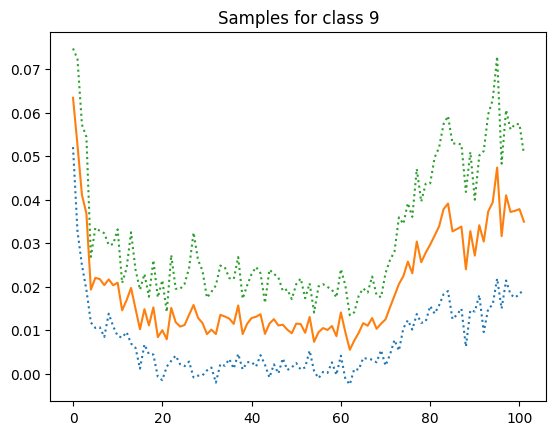

 40%|████████████████████████████▍                                          | 40000/100000 [2:59:40<2:55:11,  5.71it/s]

Iter-40000; D_loss: -0.02593952603638172; G_loss: -0.43073832988739014; C_loss: 0.018040746450424194


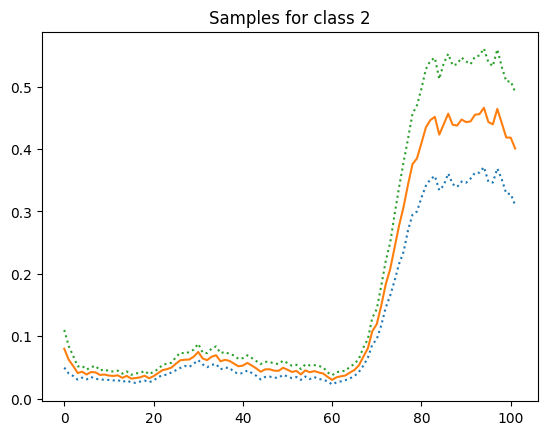

 41%|█████████████████████████████                                          | 41000/100000 [3:02:42<3:33:54,  4.60it/s]

Iter-41000; D_loss: -0.007119486108422279; G_loss: -0.24430832266807556; C_loss: 0.012554260902106762


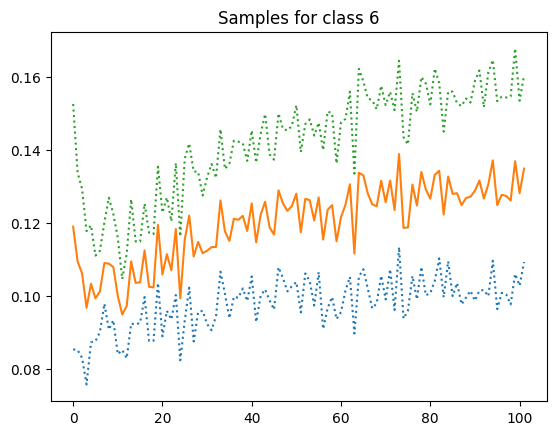

 42%|█████████████████████████████▊                                         | 42000/100000 [3:05:45<2:41:27,  5.99it/s]

Iter-42000; D_loss: -0.012811632826924324; G_loss: -0.3033106327056885; C_loss: 0.010715175420045853


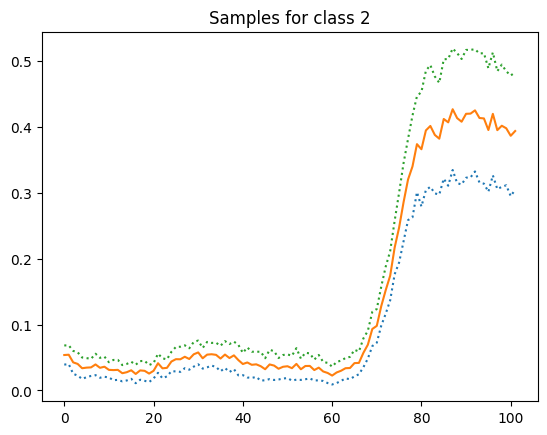

 43%|██████████████████████████████▌                                        | 43000/100000 [3:08:48<2:35:52,  6.09it/s]

Iter-43000; D_loss: 0.005636919289827347; G_loss: -0.07040359079837799; C_loss: 0.007232352625578642


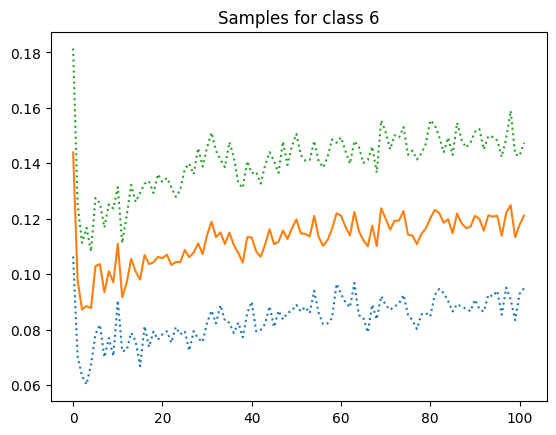

 44%|███████████████████████████████▏                                       | 44000/100000 [3:11:54<2:44:05,  5.69it/s]

Iter-44000; D_loss: -0.017901800572872162; G_loss: 0.10725859552621841; C_loss: 0.00848680641502142


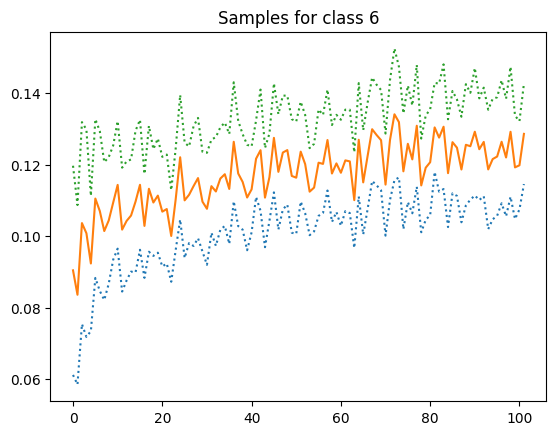

 45%|███████████████████████████████▉                                       | 45000/100000 [3:15:00<2:49:06,  5.42it/s]

Iter-45000; D_loss: -0.00371733121573925; G_loss: 0.3952566981315613; C_loss: 0.006400450132787228


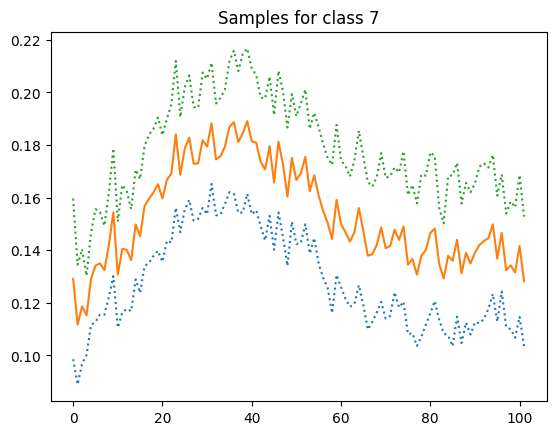

 46%|████████████████████████████████▋                                      | 46000/100000 [3:18:04<2:49:31,  5.31it/s]

Iter-46000; D_loss: 0.07740265876054764; G_loss: -0.37302255630493164; C_loss: 0.038013800978660583


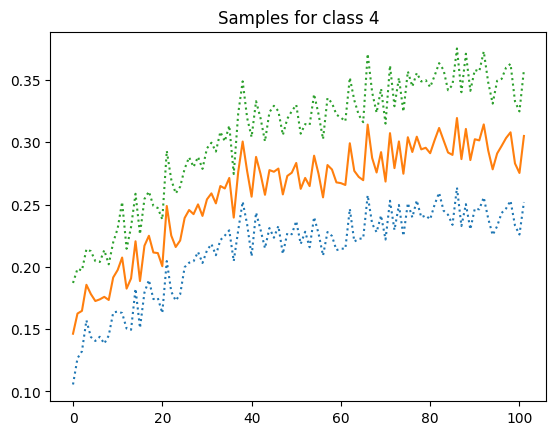

 47%|█████████████████████████████████▎                                     | 47000/100000 [3:21:26<2:55:08,  5.04it/s]

Iter-47000; D_loss: 0.015116899274289608; G_loss: 0.08867868781089783; C_loss: 0.012236334383487701


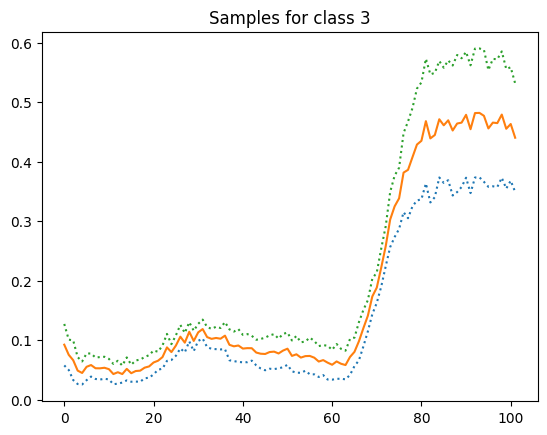

 48%|██████████████████████████████████                                     | 48000/100000 [3:24:33<2:35:36,  5.57it/s]

Iter-48000; D_loss: -0.0398312546312809; G_loss: 0.07640692591667175; C_loss: 0.021996885538101196


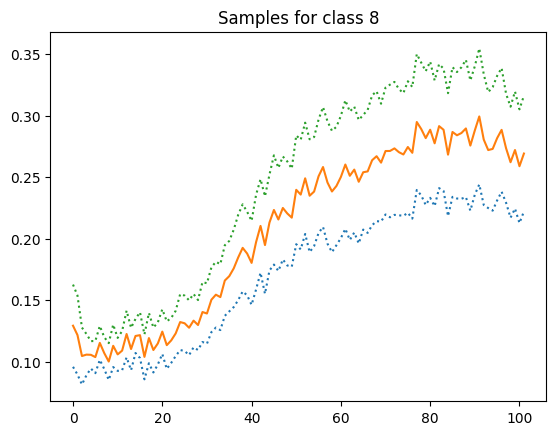

 49%|██████████████████████████████████▊                                    | 49000/100000 [3:27:40<2:37:46,  5.39it/s]

Iter-49000; D_loss: -0.002466839738190174; G_loss: 0.23759934306144714; C_loss: 0.013747310265898705


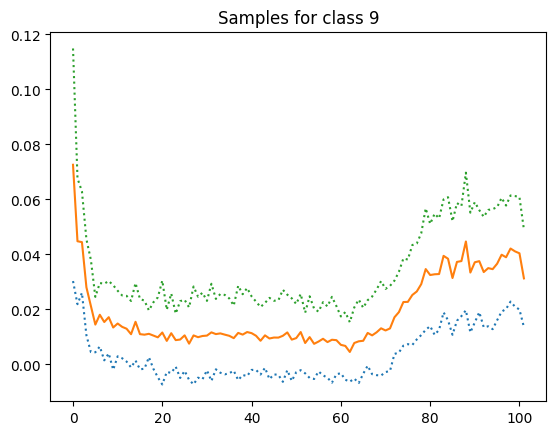

 50%|███████████████████████████████████▌                                   | 50000/100000 [3:30:42<2:33:06,  5.44it/s]

Iter-50000; D_loss: 0.001050756312906742; G_loss: -0.013423813506960869; C_loss: 0.024215390905737877


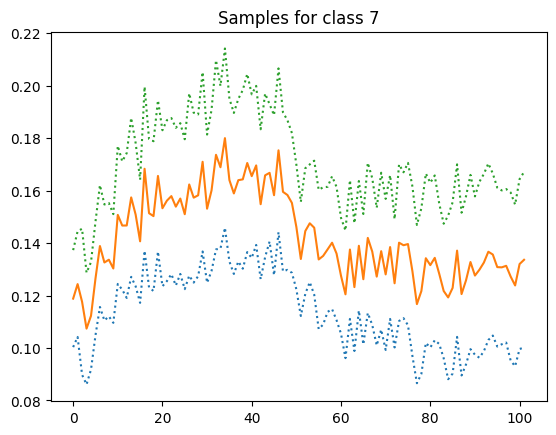

 51%|████████████████████████████████████▏                                  | 51000/100000 [3:33:49<2:20:12,  5.82it/s]

Iter-51000; D_loss: -0.01336154155433178; G_loss: 0.017311520874500275; C_loss: 0.020722566172480583


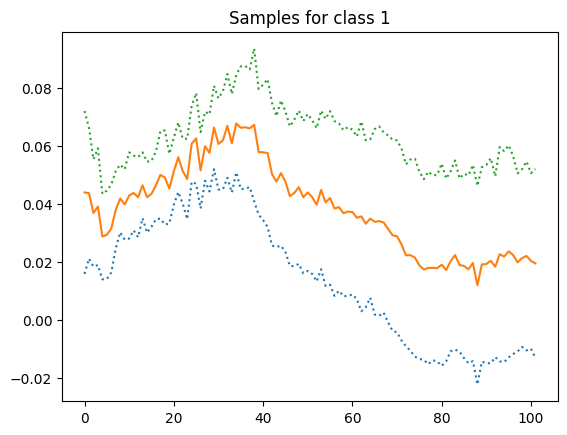

 52%|████████████████████████████████████▉                                  | 52000/100000 [3:36:53<2:13:42,  5.98it/s]

Iter-52000; D_loss: -0.00025912653654813766; G_loss: -0.07677654176950455; C_loss: 0.02993474341928959


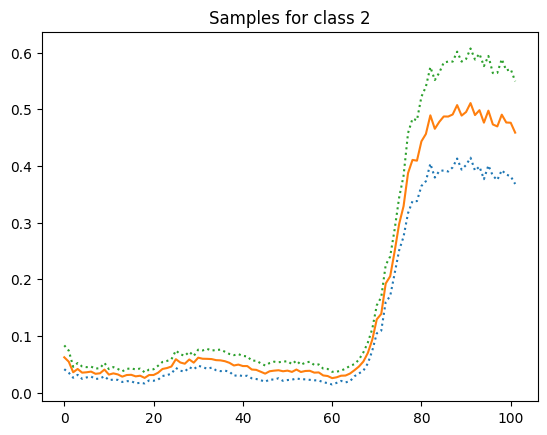

 53%|█████████████████████████████████████▋                                 | 53000/100000 [3:39:59<2:23:21,  5.46it/s]

Iter-53000; D_loss: 0.01949423737823963; G_loss: -0.0296963881701231; C_loss: 0.06213698163628578


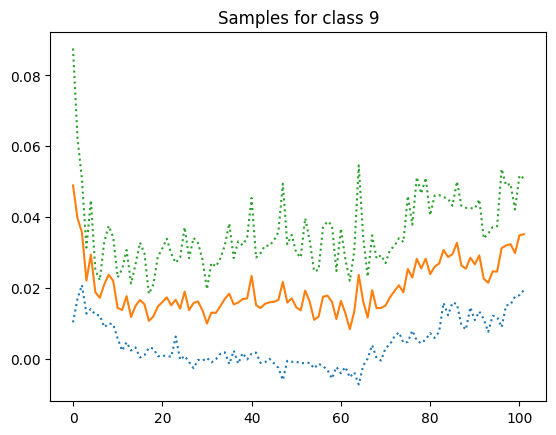

 54%|██████████████████████████████████████▎                                | 54000/100000 [3:43:03<2:18:23,  5.54it/s]

Iter-54000; D_loss: 0.07925789803266525; G_loss: -0.04702506959438324; C_loss: 0.03273146599531174


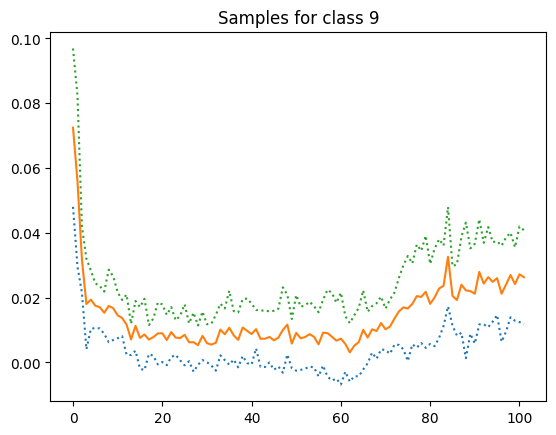

 55%|███████████████████████████████████████                                | 55000/100000 [3:46:06<2:22:49,  5.25it/s]

Iter-55000; D_loss: -0.011196672916412354; G_loss: -0.014549726620316505; C_loss: 0.021140657365322113


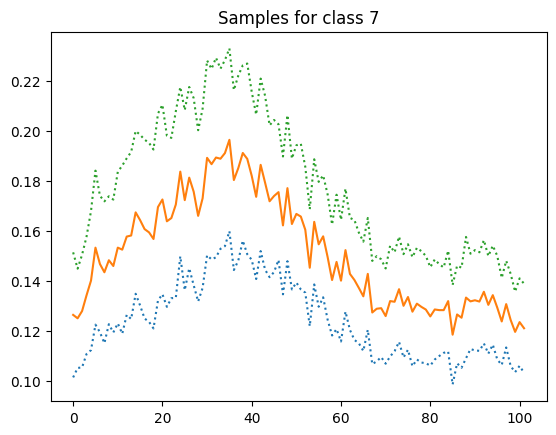

 56%|███████████████████████████████████████▊                               | 56000/100000 [3:49:11<2:10:37,  5.61it/s]

Iter-56000; D_loss: -0.024219917133450508; G_loss: -0.2244986593723297; C_loss: 0.013257015496492386


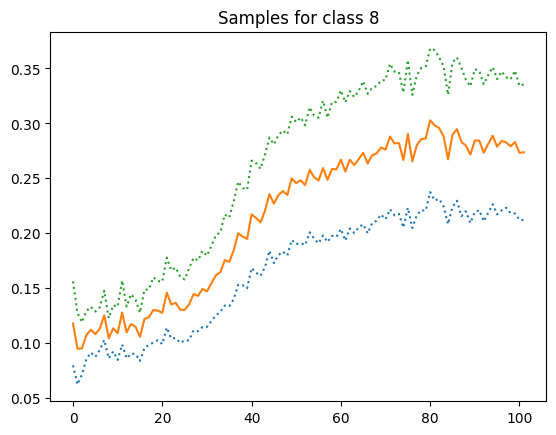

 57%|████████████████████████████████████████▍                              | 57000/100000 [3:52:15<2:07:59,  5.60it/s]

Iter-57000; D_loss: -0.0035769976675510406; G_loss: -0.1660941243171692; C_loss: 0.029248744249343872


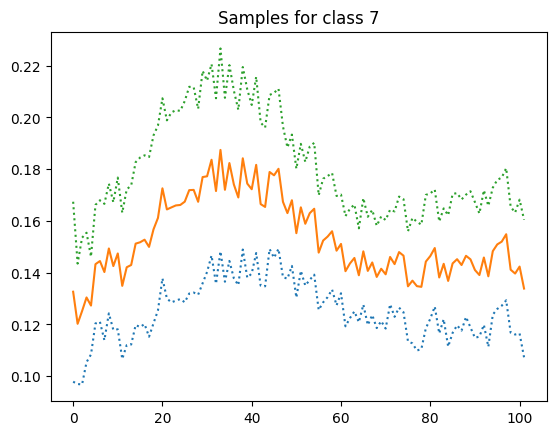

 58%|█████████████████████████████████████████▏                             | 58000/100000 [3:55:20<2:08:21,  5.45it/s]

Iter-58000; D_loss: -0.003283814527094364; G_loss: -0.2529006600379944; C_loss: 0.012792518362402916


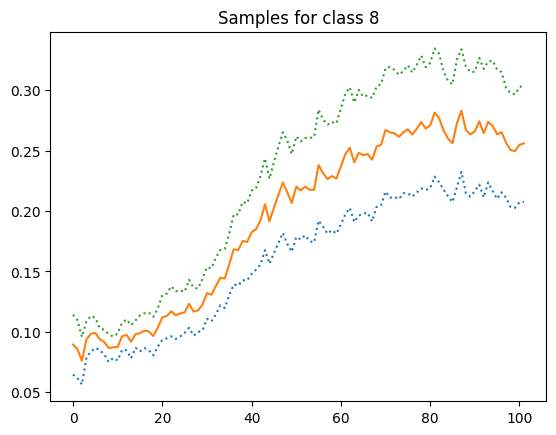

 59%|█████████████████████████████████████████▉                             | 59000/100000 [3:58:21<2:02:18,  5.59it/s]

Iter-59000; D_loss: 0.010904714465141296; G_loss: -0.5100510120391846; C_loss: 0.012792943976819515


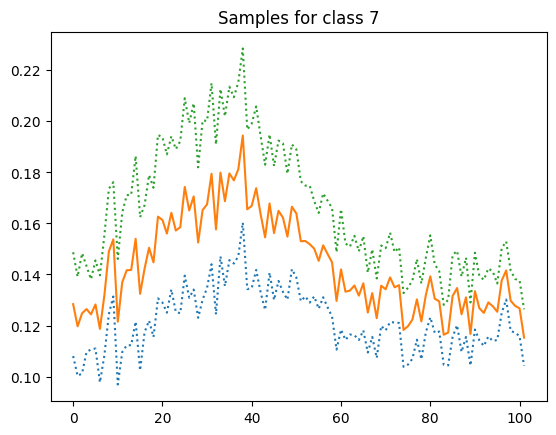

 60%|██████████████████████████████████████████▌                            | 60000/100000 [4:01:22<1:47:12,  6.22it/s]

Iter-60000; D_loss: -0.031930044293403625; G_loss: -0.20558322966098785; C_loss: 0.020956996828317642


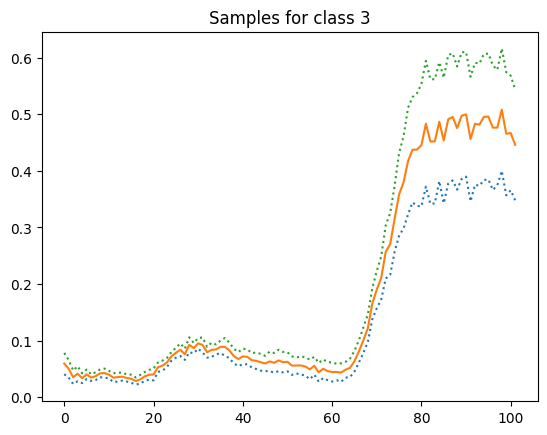

 61%|███████████████████████████████████████████▎                           | 61000/100000 [4:04:24<1:49:33,  5.93it/s]

Iter-61000; D_loss: 0.009660715237259865; G_loss: -0.12931805849075317; C_loss: 0.029932474717497826


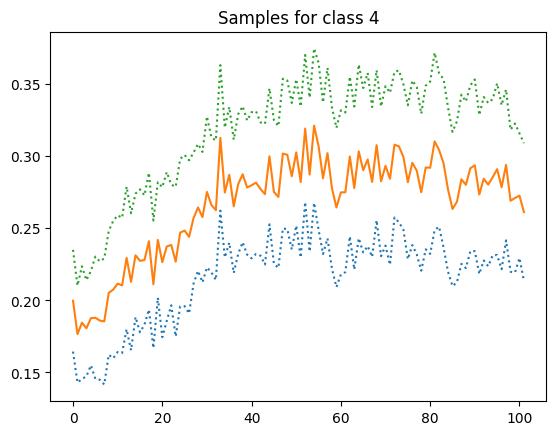

 62%|████████████████████████████████████████████                           | 62000/100000 [4:07:26<2:09:52,  4.88it/s]

Iter-62000; D_loss: -0.0535103864967823; G_loss: -0.17498674988746643; C_loss: 0.045506589114665985


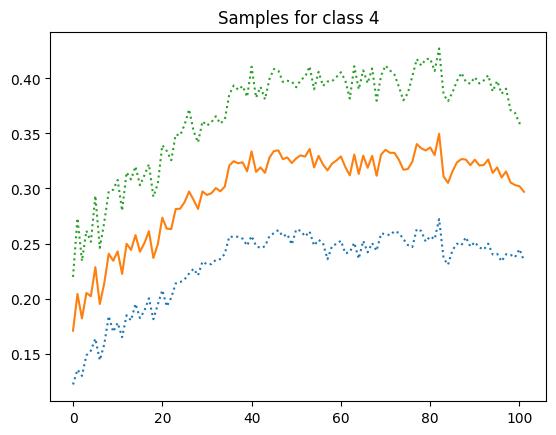

 63%|████████████████████████████████████████████▋                          | 63000/100000 [4:10:27<1:54:02,  5.41it/s]

Iter-63000; D_loss: -0.011760607361793518; G_loss: -0.5203129053115845; C_loss: 0.013998471200466156


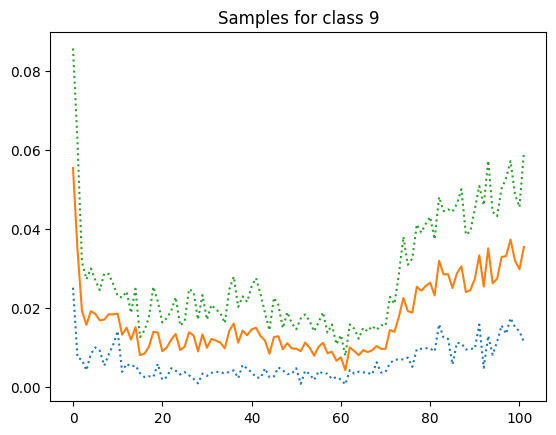

 64%|█████████████████████████████████████████████▍                         | 64000/100000 [4:13:29<1:51:11,  5.40it/s]

Iter-64000; D_loss: -0.03777023404836655; G_loss: -1.3190605640411377; C_loss: 0.017777031287550926


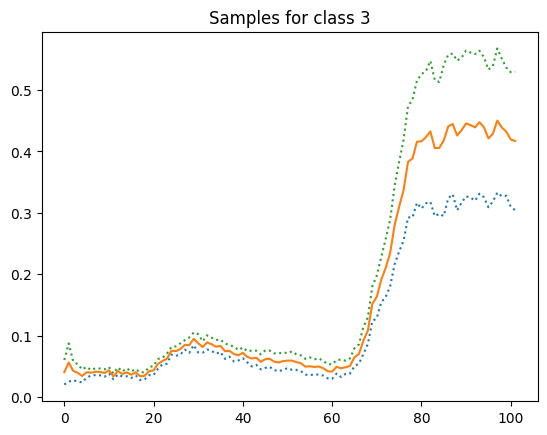

 65%|██████████████████████████████████████████████▏                        | 65000/100000 [4:16:32<1:46:28,  5.48it/s]

Iter-65000; D_loss: -0.02326062135398388; G_loss: -1.654642939567566; C_loss: 0.01155172660946846


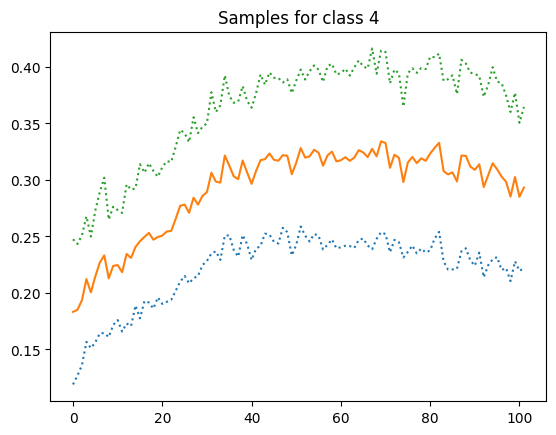

 66%|██████████████████████████████████████████████▊                        | 66000/100000 [4:19:33<1:39:58,  5.67it/s]

Iter-66000; D_loss: -0.011255440302193165; G_loss: -1.7834486961364746; C_loss: 0.01911970041692257


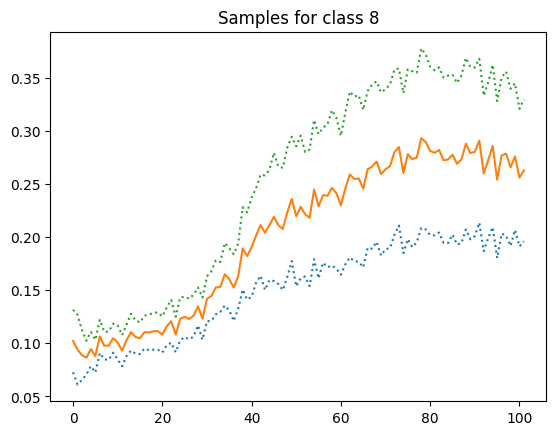

 67%|███████████████████████████████████████████████▌                       | 67000/100000 [4:24:16<2:42:42,  3.38it/s]

Iter-67000; D_loss: -0.011598392389714718; G_loss: -2.4396510124206543; C_loss: 0.00564074981957674


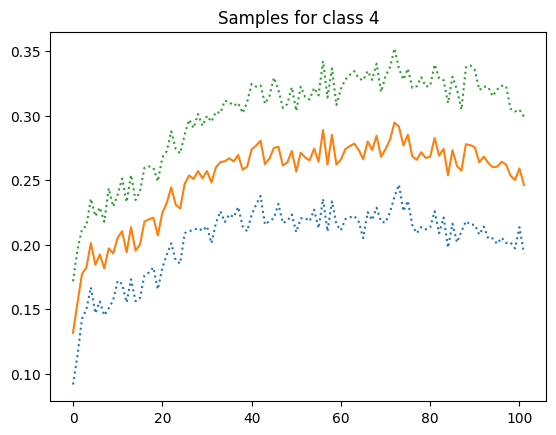

 68%|████████████████████████████████████████████████▎                      | 68000/100000 [4:29:09<2:30:45,  3.54it/s]

Iter-68000; D_loss: -0.015162177383899689; G_loss: -2.8902034759521484; C_loss: 0.010276085697114468


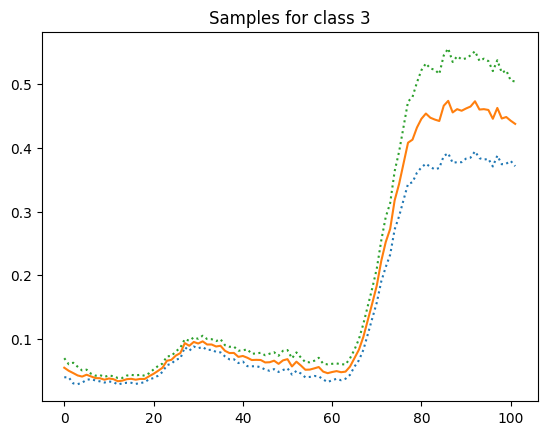

 69%|████████████████████████████████████████████████▉                      | 69000/100000 [4:33:22<1:29:50,  5.75it/s]

Iter-69000; D_loss: -0.019304601475596428; G_loss: -3.6862220764160156; C_loss: 0.0344034880399704


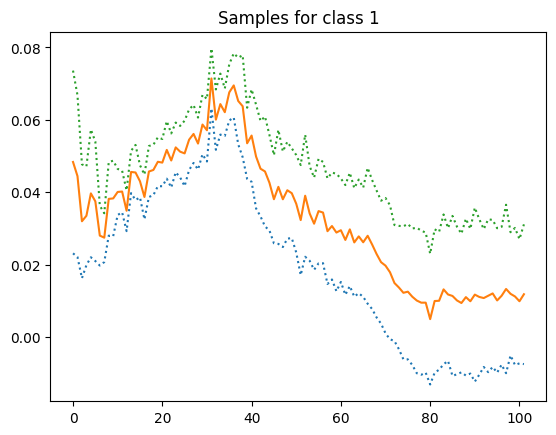

 70%|█████████████████████████████████████████████████▋                     | 70000/100000 [4:36:22<1:21:16,  6.15it/s]

Iter-70000; D_loss: -0.011506994254887104; G_loss: -4.208064079284668; C_loss: 0.010324563831090927


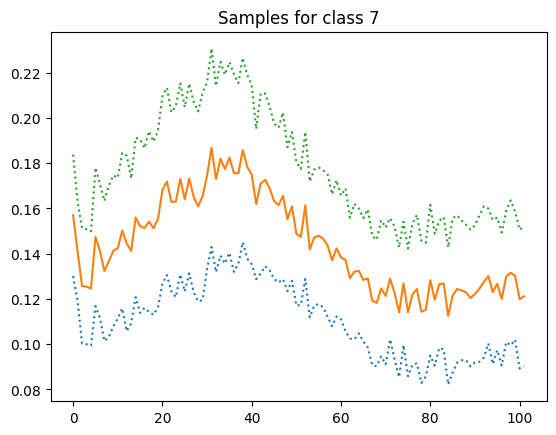

 71%|██████████████████████████████████████████████████▍                    | 71000/100000 [4:39:22<1:34:14,  5.13it/s]

Iter-71000; D_loss: 0.023328594863414764; G_loss: -5.023672103881836; C_loss: 0.005119137931615114


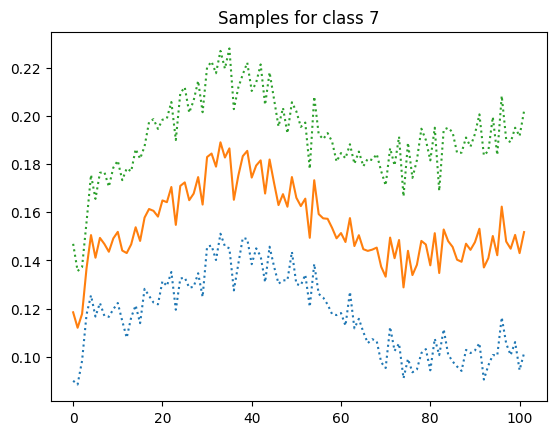

 72%|███████████████████████████████████████████████████                    | 72000/100000 [4:42:23<1:22:56,  5.63it/s]

Iter-72000; D_loss: -0.014620080590248108; G_loss: -5.647434234619141; C_loss: 0.005972013343125582


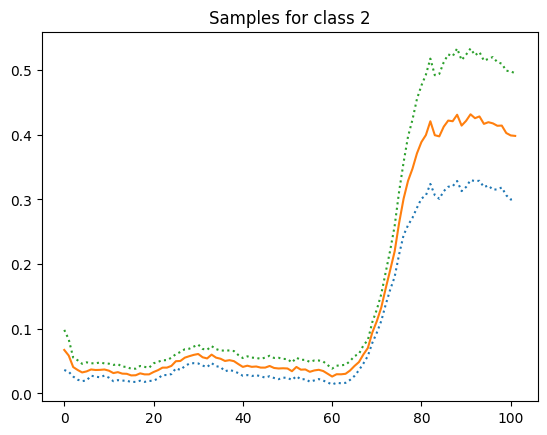

 73%|███████████████████████████████████████████████████▊                   | 73000/100000 [4:45:24<1:18:12,  5.75it/s]

Iter-73000; D_loss: -0.018686536699533463; G_loss: -6.434175968170166; C_loss: 0.011953282169997692


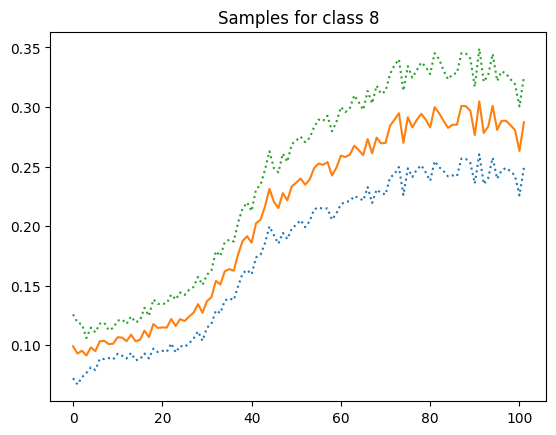

 74%|████████████████████████████████████████████████████▌                  | 74000/100000 [4:48:26<1:13:51,  5.87it/s]

Iter-74000; D_loss: -0.0052728429436683655; G_loss: -7.041067123413086; C_loss: 0.018542848527431488


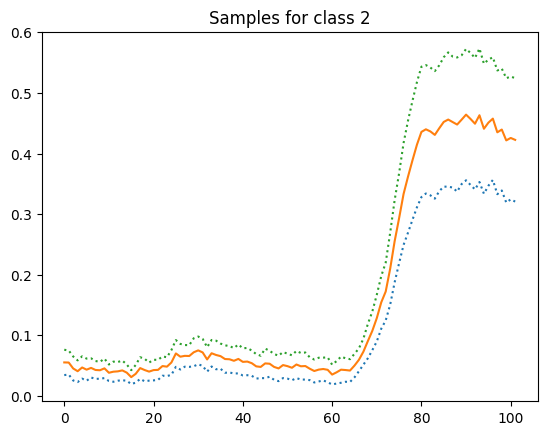

 75%|█████████████████████████████████████████████████████▎                 | 75000/100000 [4:51:26<1:28:10,  4.73it/s]

Iter-75000; D_loss: -0.010212658904492855; G_loss: -7.599081039428711; C_loss: 0.006711889058351517


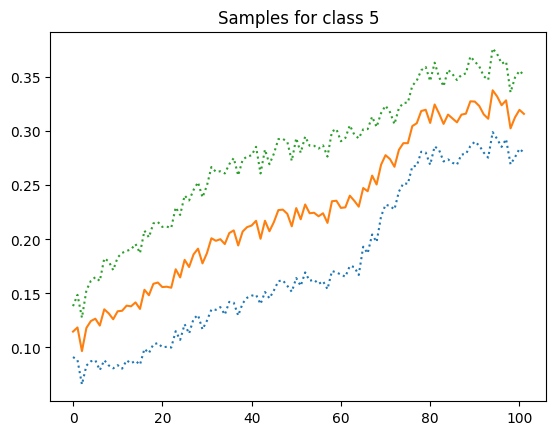

 76%|█████████████████████████████████████████████████████▉                 | 76000/100000 [4:54:28<1:51:38,  3.58it/s]

Iter-76000; D_loss: -0.02158932574093342; G_loss: -8.346181869506836; C_loss: 0.006126240361481905


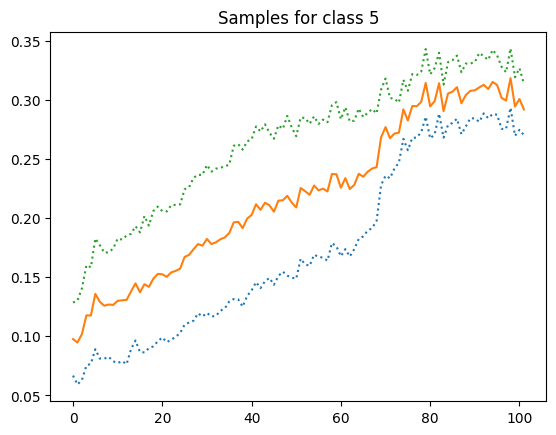

 77%|██████████████████████████████████████████████████████▋                | 77000/100000 [4:57:29<1:23:36,  4.58it/s]

Iter-77000; D_loss: -0.012172175571322441; G_loss: -8.600724220275879; C_loss: 0.01351173035800457


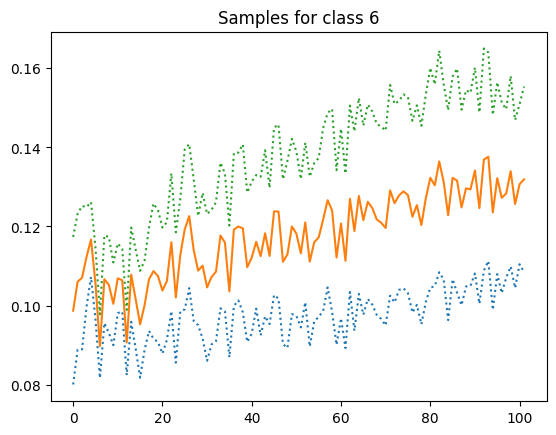

 78%|███████████████████████████████████████████████████████▍               | 78000/100000 [5:00:31<1:09:29,  5.28it/s]

Iter-78000; D_loss: -0.037492603063583374; G_loss: -8.979848861694336; C_loss: 0.00823201797902584


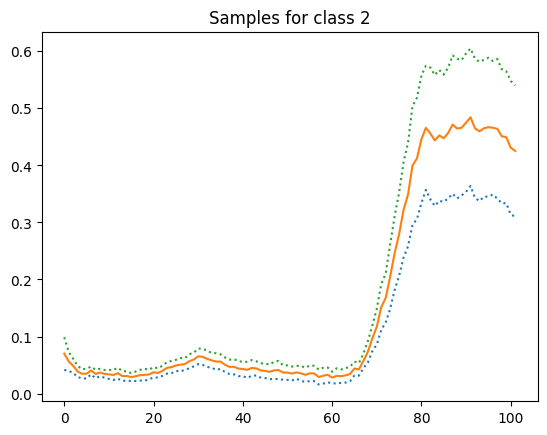

 79%|████████████████████████████████████████████████████████               | 79000/100000 [5:03:34<1:06:23,  5.27it/s]

Iter-79000; D_loss: -0.016869816929101944; G_loss: -9.623690605163574; C_loss: 0.011979058384895325


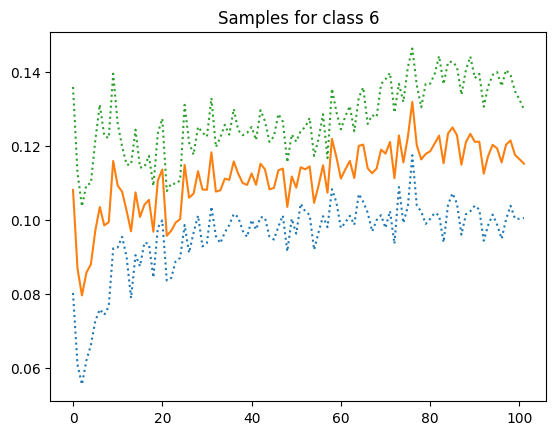

 80%|████████████████████████████████████████████████████████▊              | 80000/100000 [5:06:34<1:05:41,  5.07it/s]

Iter-80000; D_loss: -0.006591620855033398; G_loss: -10.43934154510498; C_loss: 0.008232069201767445


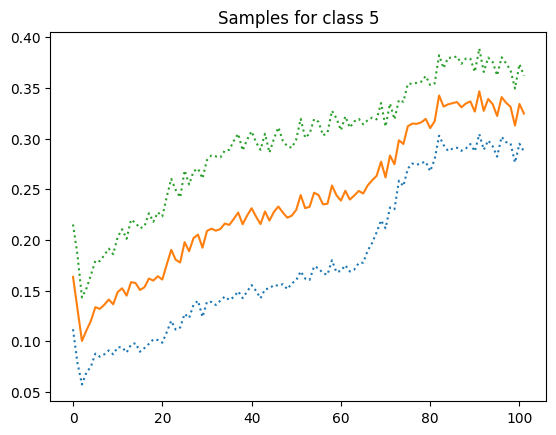

 81%|███████████████████████████████████████████████████████████▏             | 81000/100000 [5:09:36<58:26,  5.42it/s]

Iter-81000; D_loss: -0.020094139501452446; G_loss: -11.115132331848145; C_loss: 0.009593915194272995


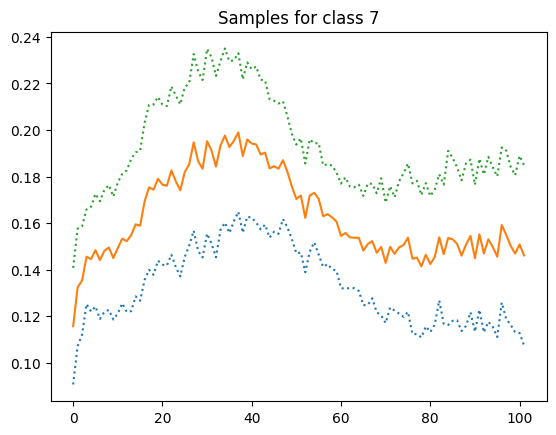

 82%|███████████████████████████████████████████████████████████▊             | 82000/100000 [5:12:40<51:38,  5.81it/s]

Iter-82000; D_loss: -0.010945950634777546; G_loss: -11.479126930236816; C_loss: 0.009821752086281776


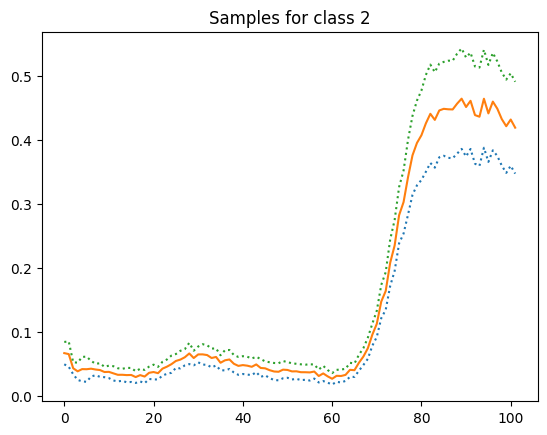

 83%|████████████████████████████████████████████████████████████▌            | 83000/100000 [5:15:44<52:00,  5.45it/s]

Iter-83000; D_loss: -0.02598213031888008; G_loss: -11.934219360351562; C_loss: 0.009883333928883076


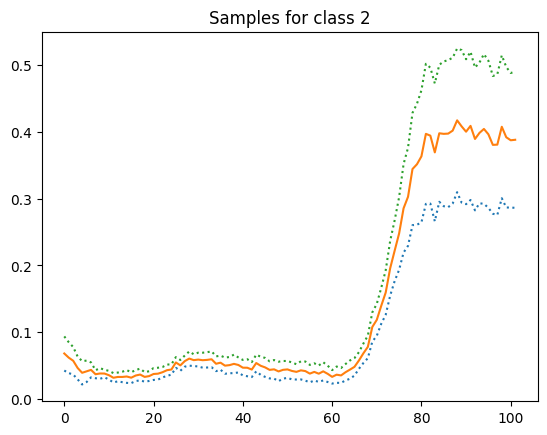

 84%|█████████████████████████████████████████████████████████████▎           | 84000/100000 [5:18:45<51:07,  5.22it/s]

Iter-84000; D_loss: -0.0017181988805532455; G_loss: -12.381254196166992; C_loss: 0.006110740825533867


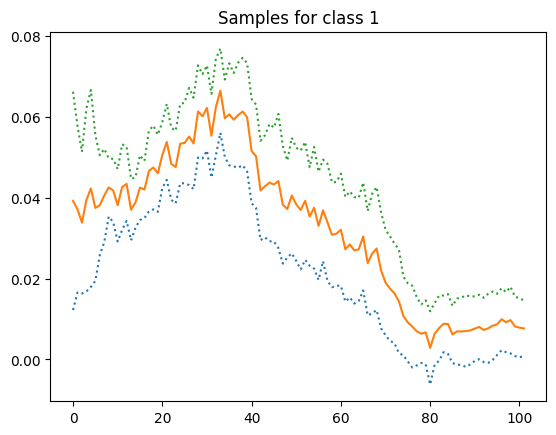

 85%|██████████████████████████████████████████████████████████████           | 85000/100000 [5:21:47<45:11,  5.53it/s]

Iter-85000; D_loss: -0.029373958706855774; G_loss: -12.580099105834961; C_loss: 0.008116666227579117


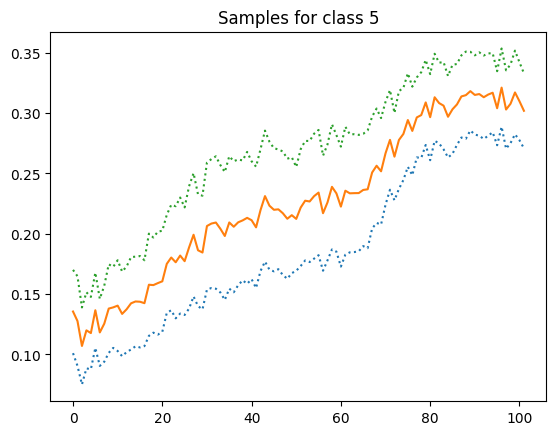

 86%|██████████████████████████████████████████████████████████████▊          | 86000/100000 [5:24:50<43:13,  5.40it/s]

Iter-86000; D_loss: -0.0019742916338145733; G_loss: -12.953116416931152; C_loss: 0.019685490056872368


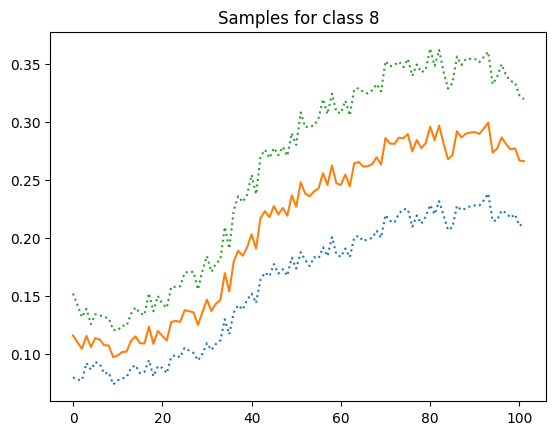

 87%|███████████████████████████████████████████████████████████████▌         | 87000/100000 [5:27:52<37:32,  5.77it/s]

Iter-87000; D_loss: -0.013550344854593277; G_loss: -13.427373886108398; C_loss: 0.009733742102980614


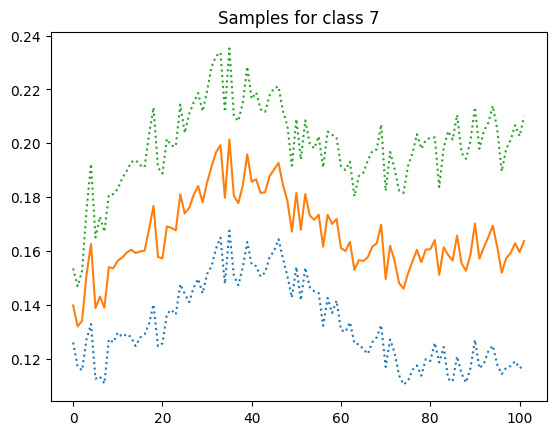

 88%|████████████████████████████████████████████████████████████████▏        | 88000/100000 [5:30:53<37:35,  5.32it/s]

Iter-88000; D_loss: -0.009068395011126995; G_loss: -13.697404861450195; C_loss: 0.005964526440948248


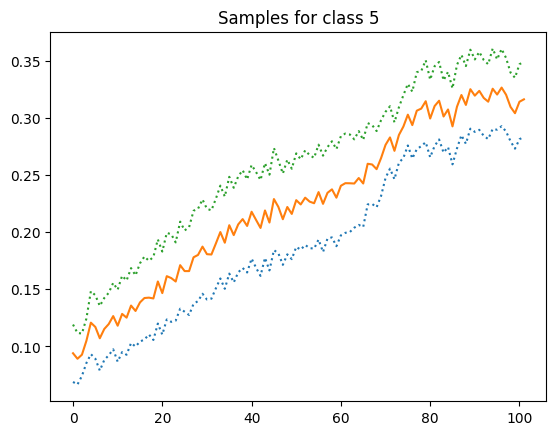

 89%|████████████████████████████████████████████████████████████████▉        | 89000/100000 [5:33:57<29:33,  6.20it/s]

Iter-89000; D_loss: -0.0005882997065782547; G_loss: -13.944135665893555; C_loss: 0.014705576002597809


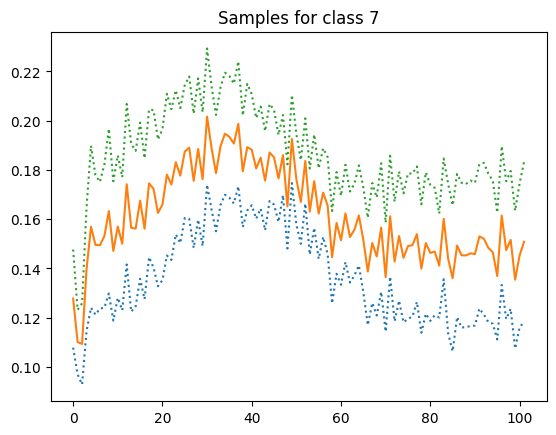

 90%|█████████████████████████████████████████████████████████████████▋       | 90000/100000 [6:22:38<28:47,  5.79it/s]

Iter-90000; D_loss: -0.009181400761008263; G_loss: -14.268556594848633; C_loss: 0.004626819863915443


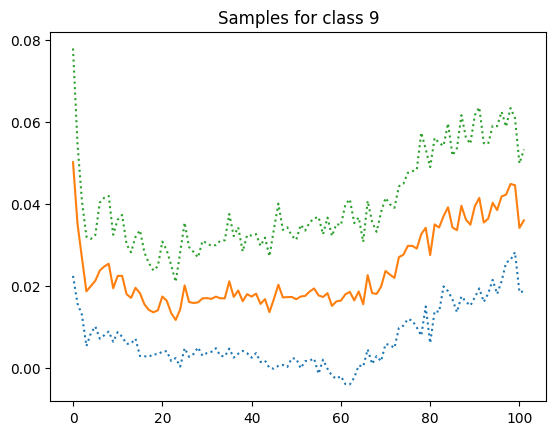

 91%|██████████████████████████████████████████████████████████████████▍      | 91000/100000 [6:25:33<26:29,  5.66it/s]

Iter-91000; D_loss: -0.02181091532111168; G_loss: -14.451045989990234; C_loss: 0.01718791387975216


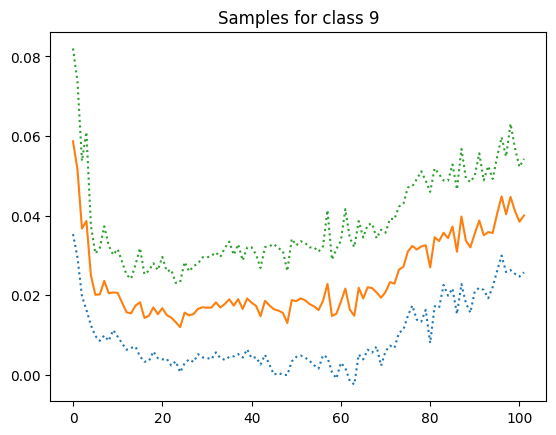

 92%|███████████████████████████████████████████████████████████████████▏     | 92000/100000 [6:28:34<21:56,  6.08it/s]

Iter-92000; D_loss: -0.007988354191184044; G_loss: -14.644506454467773; C_loss: 0.012990651652216911


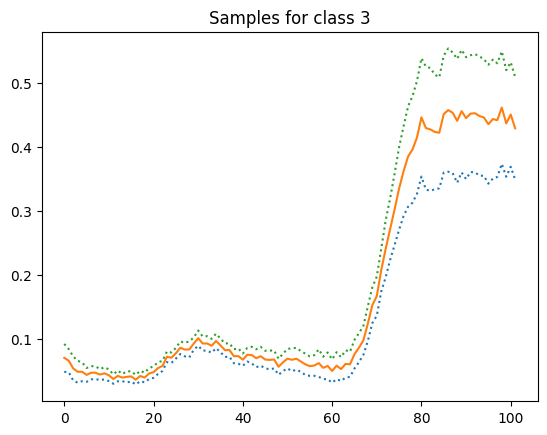

 93%|███████████████████████████████████████████████████████████████████▉     | 93000/100000 [6:32:11<33:09,  3.52it/s]

Iter-93000; D_loss: -0.028412435203790665; G_loss: -14.902508735656738; C_loss: 0.007893010973930359


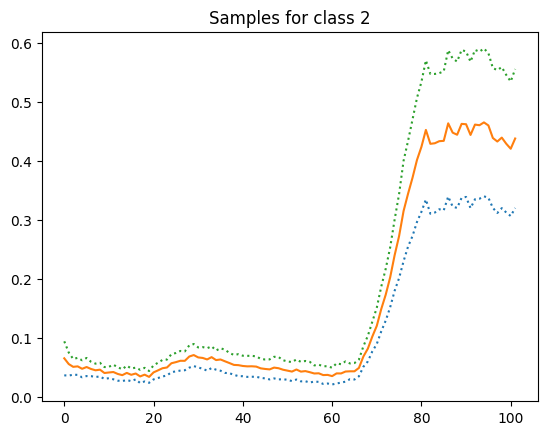

 94%|████████████████████████████████████████████████████████████████████▌    | 94000/100000 [6:37:21<37:39,  2.66it/s]

Iter-94000; D_loss: -0.009064940735697746; G_loss: -15.095396041870117; C_loss: 0.0073409304022789


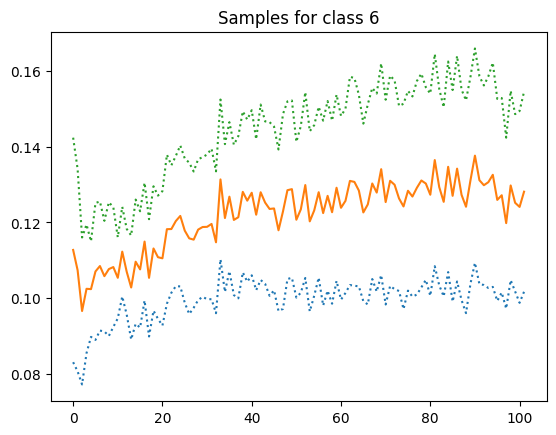

 95%|█████████████████████████████████████████████████████████████████████▎   | 95000/100000 [6:43:55<32:01,  2.60it/s]

Iter-95000; D_loss: -0.02912958338856697; G_loss: -15.45069694519043; C_loss: 0.01253475621342659


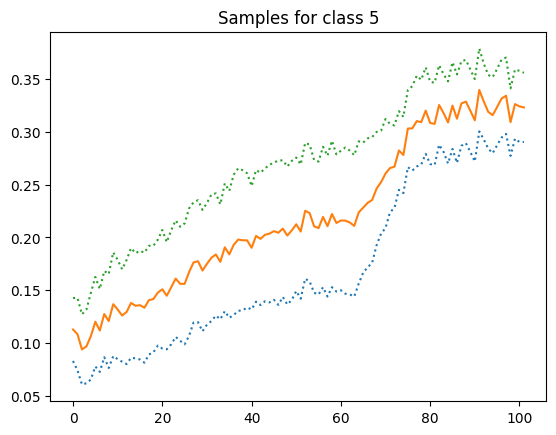

 96%|██████████████████████████████████████████████████████████████████████   | 96000/100000 [6:49:38<16:34,  4.02it/s]

Iter-96000; D_loss: 0.009214777499437332; G_loss: -15.695591926574707; C_loss: 0.008875411935150623


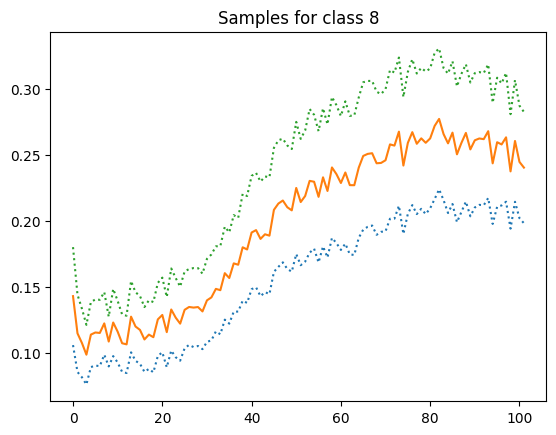

 97%|██████████████████████████████████████████████████████████████████████▊  | 97000/100000 [6:54:23<08:01,  6.23it/s]

Iter-97000; D_loss: -0.013484988361597061; G_loss: -16.13091278076172; C_loss: 0.01126908604055643


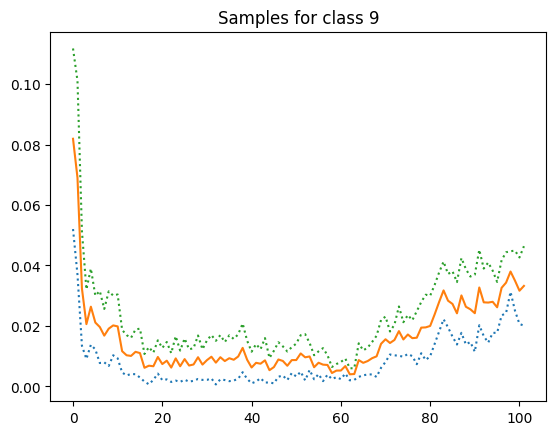

 98%|███████████████████████████████████████████████████████████████████████▌ | 98000/100000 [6:57:25<06:03,  5.50it/s]

Iter-98000; D_loss: -0.01633218675851822; G_loss: -16.30258560180664; C_loss: 0.013542557135224342


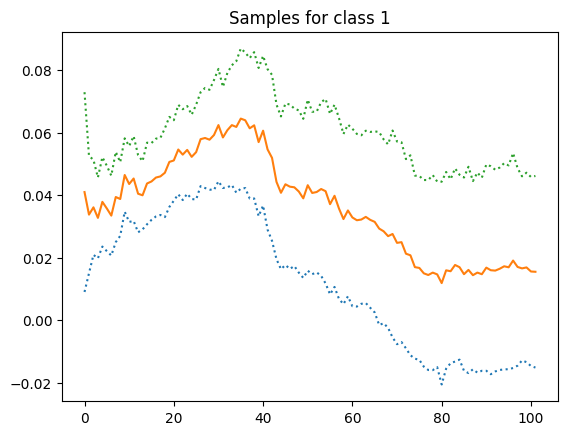

 99%|████████████████████████████████████████████████████████████████████████▎| 99000/100000 [7:00:47<04:16,  3.89it/s]

Iter-99000; D_loss: -0.04109511524438858; G_loss: -16.43867301940918; C_loss: 0.007322794292122126


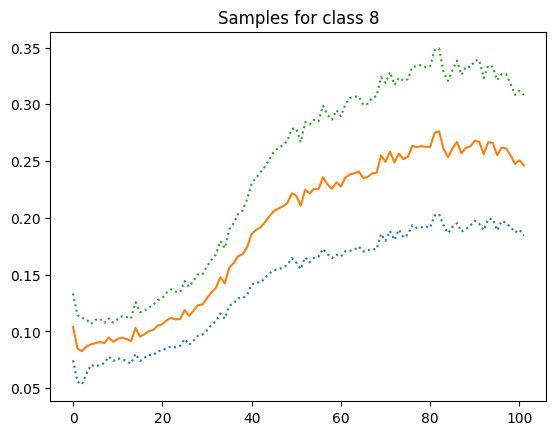

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [7:04:19<00:00,  3.93it/s]


In [9]:
import torch.optim as optim
# Get networks
G = Generator().cuda()
D = Discriminator().cuda()
C = Classifier().cuda()
# Use RMSProp optimizer
G_solver = optim.RMSprop(G.parameters(), lr=lr)
D_solver = optim.RMSprop(D.parameters(), lr=lr)
C_solver = optim.RMSprop(C.parameters(), lr=lr)

for it in tqdm(range(100000)):
    ###########################
    # (1) Update C and D      #
    ###########################
    for p in D.parameters():  # reset requires_grad
        p.requires_grad = True  # they are set to False below in netG update
    for p in C.parameters():
        p.requires_grad = True
    
    # D is trained d_step times for each iteration
    for _, (X, y), (X_, y_) in zip(range(d_step), data_loader, data_loader):
        D.zero_grad()

        # Sample random noise
        z = torch.randn(y.size(0), z_dim).squeeze()
        X, y = X.float(), y.float()
        X_, y_ = X_.float(), y_.float()
        # Mixup
        lam = np.random.beta(mixup_alpha, mixup_alpha)
        X = lam*X + (1. - lam)*X_
        X, y, z = X.cuda(), y.cuda(), z.cuda()
        y_ = y_.cuda()
        
        # Get discriminator prediction on real samples
        D_real = D(X).mean()
        # Get discriminator prediction on fake samples
        fake_samples = G(z, y)
        D_fake = D(fake_samples).mean()
        # Compute gradient penalty
        gradient_penalty = calc_gradient_penalty(D, X.data, fake_samples.data)
        # Compute loss and backpropagate
        D_loss = D_fake - D_real + gradient_penalty
        flip = np.random.random() < flip_percentage
        if flip: 
            # Flip real and fake
            gradient_penalty = calc_gradient_penalty(D, fake_samples.data, X.data)
            D_loss = D_real - D_fake + gradient_penalty
        D_loss.backward()
        D_solver.step()
    
        ######################
        #  Update C network  #
        ######################
        C.zero_grad()
        # Get class values
        _, classes = torch.max(y, dim=1)
        _, classes_ = torch.max(y_, dim=1)
        # Get predictions from C
        if flip:
            fake_samples = G(z, y)
            pred = C(fake_samples)
            # Compute loss and backpropagate
            C_loss = F.cross_entropy(pred, classes, weight=class_weights)
        else:
            pred = F.log_softmax(C(X))
            C_loss = lam * F.nll_loss(pred, classes) + (1. - lam) * F.nll_loss(pred, classes_)
        C_loss.backward()
        C_solver.step()


    ############################
    # (2) Update G network
    ###########################
    for p in D.parameters():
        p.requires_grad = False  # to avoid computation
    for p in C.parameters():
        p.requires_grad = False
    reset_grad(C, G, D)

    # Sample random noise
    z = torch.randn(y.size(0), z_dim).squeeze()
    z = z.cuda()
    # Generate fake samples
    G_sample = G(z, y)
    D_fake = D(G_sample)
    pred = C(G_sample)
    C_loss = F.cross_entropy(pred, classes, weight=class_weights)
    # Fool the discriminator (WGAN)
    G_loss = -torch.mean(D_fake)
    # Include the auxialiary classifier loss (AC-GAN)
    loss = G_loss + c_weight * C_loss
    # Backpropagate
    loss.backward()
    G_solver.step()

    # Print and plot every now and then
    if it % 1000 == 0:
        with torch.no_grad():
            print('Iter-{}; D_loss: {}; G_loss: {}; C_loss: {}'.format(it,
                                                           D_loss.data.cpu().numpy(), G_loss.data.cpu().numpy(),
                                                           C_loss.data.cpu().numpy()))
            z = torch.randn(mb_size, z_dim).squeeze().cuda()
            c = np.zeros(shape=[mb_size, c_dim], dtype='float32')
            idx = np.random.randint(1, data_loader.dataset.n_classes)
            c[:, idx] = 1.
            c = torch.from_numpy(c).squeeze().cuda()
            samples = G(z, c).data.cpu().numpy()[:16]
            pred = G(z, c)
            plot_mean_std(samples)
            plt.title("Samples for class {}".format(idx))
            plt.show()


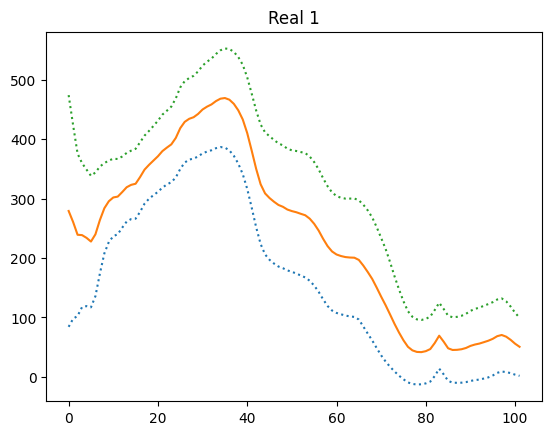

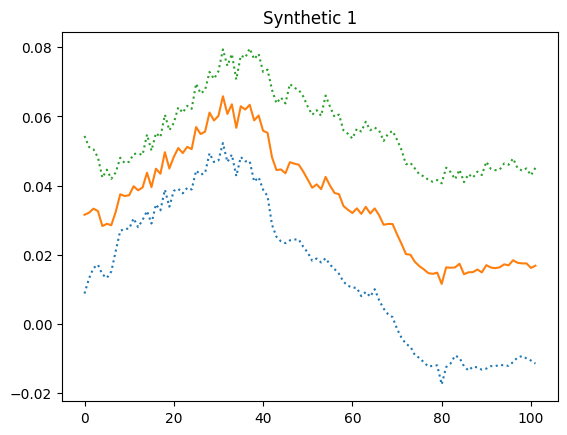

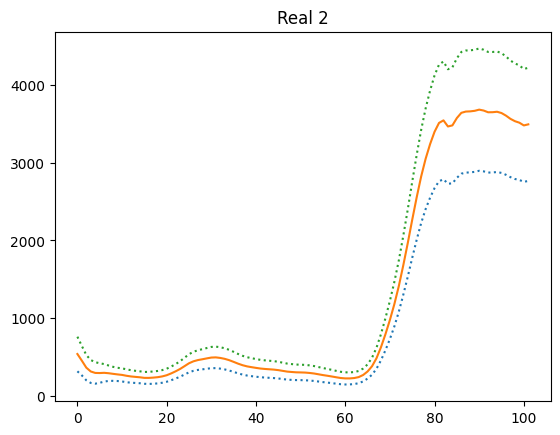

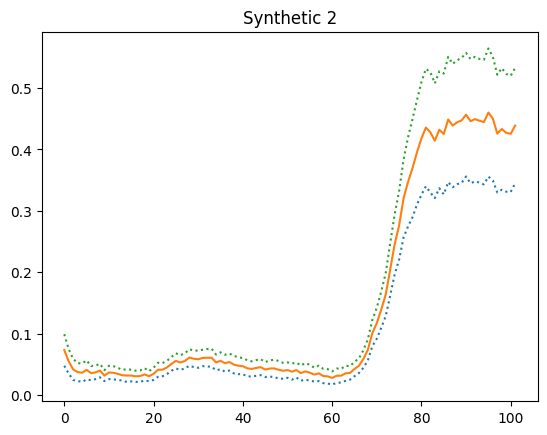

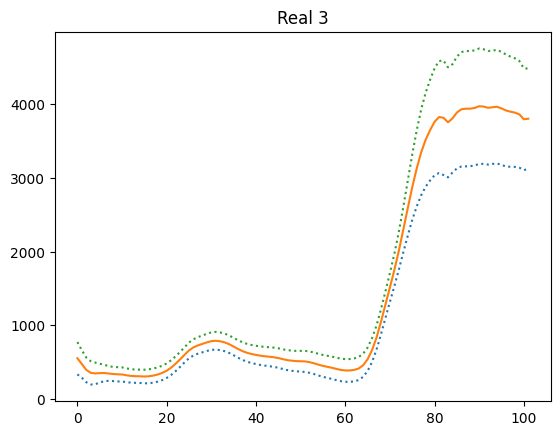

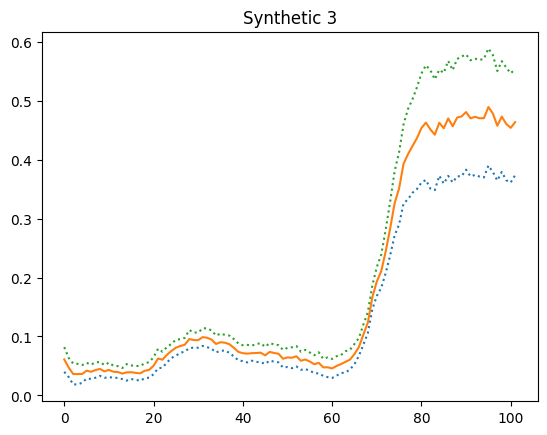

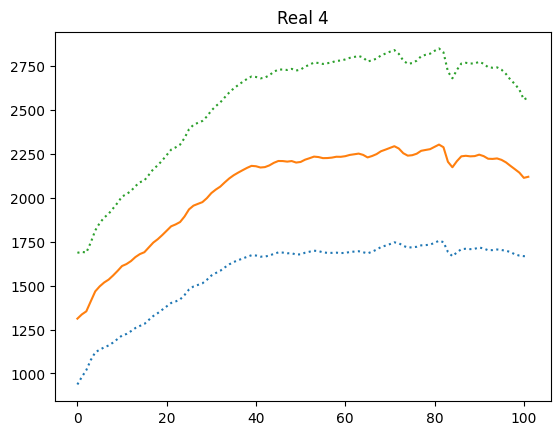

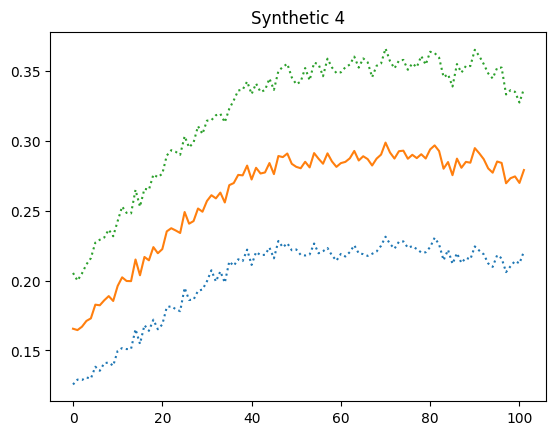

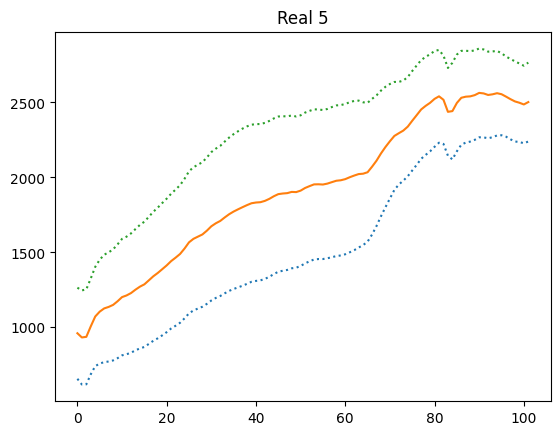

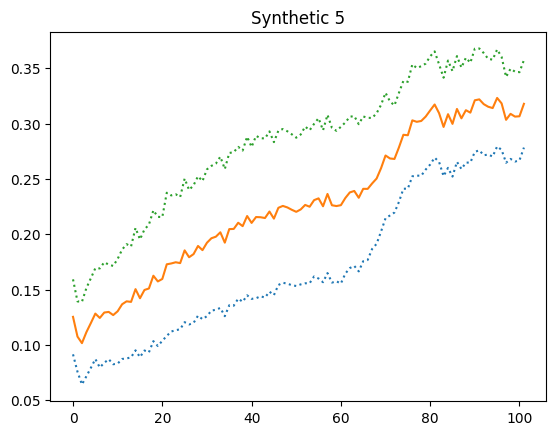

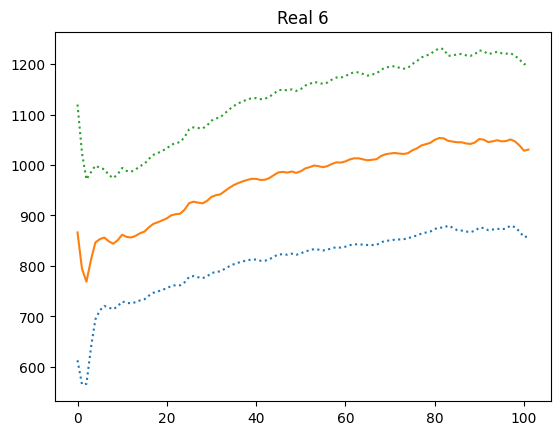

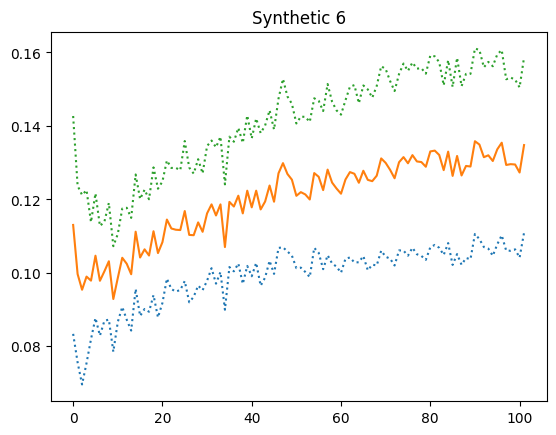

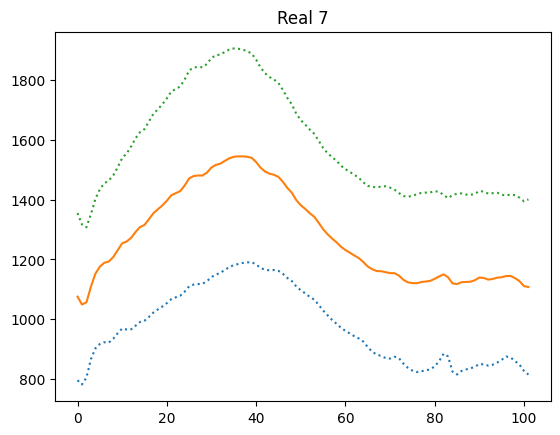

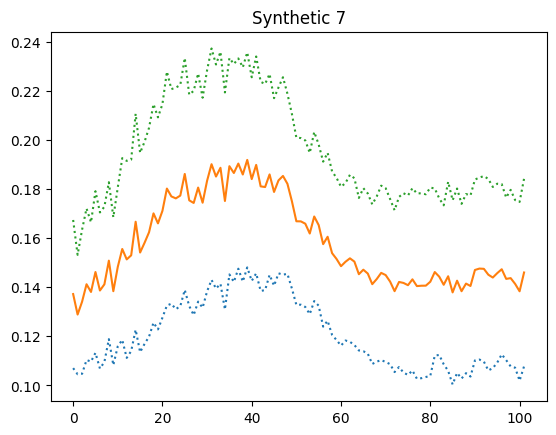

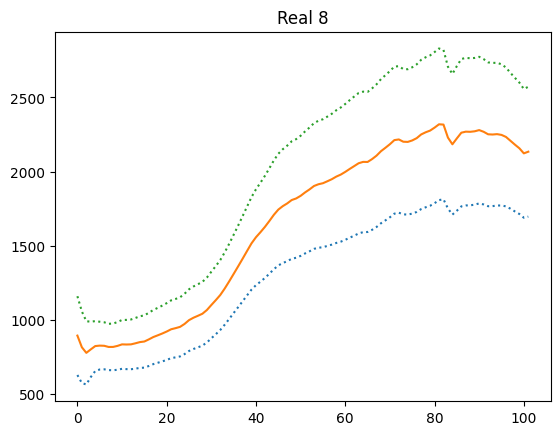

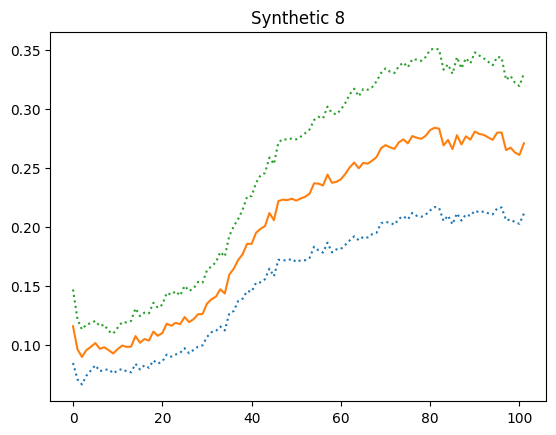

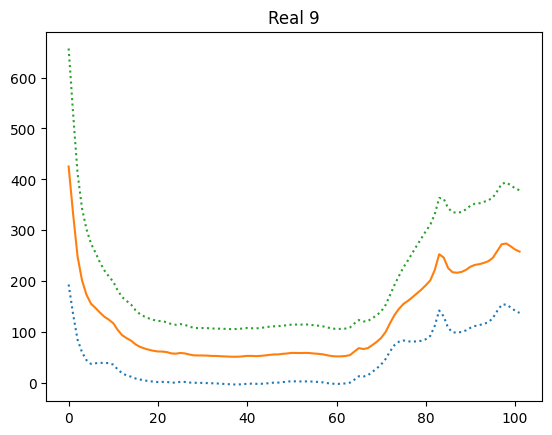

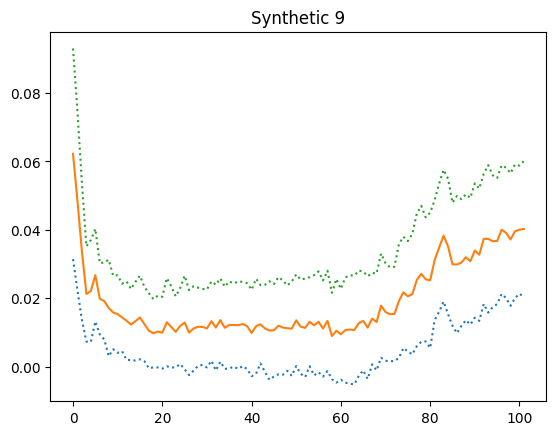

In [10]:
for c in np.unique(gt):
    # 0 is the "undefined" class
    if c == 0:
        continue
    
    # Get the mean spectrum +- std for this class
    spectras = img[gt == c, :]
    plot_mean_std(spectras)
    plt.title("Real {}".format(c))
    plt.show()
    
    # Get as many fake spectras as real ones
    synthetic_spectras = []
    with torch.no_grad():
        while len(synthetic_spectras) < len(spectras):
            z = torch.randn(mb_size, z_dim).cuda()
            y = torch.from_numpy(np.eye(data_loader.dataset.n_classes)[c]).float()
            y = y.unsqueeze(0).repeat(mb_size, 1).cuda()
            G_sample = G(z, y)
            _, classes = torch.max(y, 1)
            _, pred = torch.max(C(G_sample), 1)
            synthetic_spectras += list(G_sample.cpu().data.numpy())
    plt.show()
    plot_mean_std(synthetic_spectras)
    plt.title("Synthetic {}".format(c))
    plt.show()

In [11]:
import sklearn.svm
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.mixture

In [12]:
img = (img - img.min()) / (img.max() - img.min())
X_train = np.array([img[x,y] for x,y in zip(*np.nonzero(train_gt))])
y_train = np.array([gt[x,y] for x,y in zip(*np.nonzero(train_gt))])
X_test = np.array([img[x,y] for x,y in zip(*np.nonzero(test_gt))])
y_test = np.array([test_gt[x,y] for x,y in zip(*np.nonzero(test_gt))])

In [13]:
gmms = [sklearn.mixture.GaussianMixture(n_components=20) for _ in range(c_dim)]
for y in np.unique(y_train):
    gmms[y].fit(X_train[y_train == y])

In [14]:
def gmm_create_fake_dataset(gmms, y):
    fake_X = []
    y_fake = []
    for y in np.unique(y):
        n_samples = np.count_nonzero(y_test == y)
        samples = gmms[y].sample(n_samples)[0]
        fake_X.append(samples)
        y_fake += [y] * n_samples
    fake_X = np.concatenate(fake_X)
    y_fake = np.array(y_fake)
    return fake_X, y_fake

#fake_X_train, fake_y_train = gmm_create_fake_dataset(gmms, y_train)
#fake_X_test, fake_y_test = gmm_create_fake_dataset(gmms, y_test)

In [15]:
scaler = sklearn.preprocessing.StandardScaler()
svm = sklearn.svm.SVC()
#estimator = sklearn.pipeline.Pipeline(steps=[('scaler', scaler), ('svm', svm)])
estimator = sklearn.pipeline.Pipeline(steps=[('svm', svm)])
#tuned_parameters = {'svm__C': [0.1, 1, 10, 100, 1000], 'svm__kernel': ['linear']}
tuned_parameters = {'svm__C': [1000], 'svm__kernel': ['linear']}
clf = sklearn.model_selection.GridSearchCV(estimator, tuned_parameters, cv=5, n_jobs=4)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
best_params = clf.best_params_
print("The best SVM was obtained using {} and performed at {:.2f} accuracy.".format(best_params, 100 * score))

The best SVM was obtained using {'svm__C': 1000, 'svm__kernel': 'linear'} and performed at 98.65 accuracy.


In [16]:
y_pred = clf.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00     62815
           2       0.98      0.96      0.97      7241
           3       0.90      0.94      0.92      2939
           4       0.81      0.83      0.82      2539
           5       0.95      0.95      0.95      6250
           6       0.96      0.98      0.97      8817
           7       0.96      0.94      0.95      6892
           8       1.00      1.00      1.00     40676
           9       1.00      1.00      1.00      2735

    accuracy                           0.99    140904
   macro avg       0.95      0.96      0.95    140904
weighted avg       0.99      0.99      0.99    140904



In [17]:
def gan_create_fake_dataset(labels):
    with torch.no_grad():
        spectras = []
        for l in np.array_split(labels, len(labels) // mb_size):
            z = torch.randn(len(l), z_dim).cuda()
            y = np.zeros((len(l), data_loader.dataset.n_classes))
            for i, label in enumerate(l):
                y[i] = np.eye(data_loader.dataset.n_classes)[label]
            y = torch.from_numpy(y).float()
            eps = torch.randn(y.size())/10
            #y += eps
            y = y.cuda()
            G_sample = G(z, y)
            spectras += list(G_sample.cpu().data.numpy())
        return np.array(spectras), np.array(labels)

In [18]:
fake_X_train, fake_y_train = gan_create_fake_dataset(y_train)
fake_X_test, fake_y_test = gan_create_fake_dataset(y_test)

In [19]:
clf.score(fake_X_test, fake_y_test)

0.9796882984159427

In [20]:
y_fake_pred = clf.predict(fake_X_test)
from sklearn.metrics import classification_report
print(classification_report(fake_y_test, y_fake_pred))

              precision    recall  f1-score   support

           1       1.00      0.96      0.98     62815
           2       0.94      1.00      0.97      7241
           3       0.99      0.99      0.99      2939
           4       1.00      1.00      1.00      2539
           5       1.00      1.00      1.00      6250
           6       0.97      1.00      0.98      8817
           7       0.81      1.00      0.90      6892
           8       0.99      1.00      1.00     40676
           9       0.94      0.92      0.93      2735

    accuracy                           0.98    140904
   macro avg       0.96      0.98      0.97    140904
weighted avg       0.98      0.98      0.98    140904



In [21]:
svm_fake = sklearn.svm.SVC()
clf_fake = sklearn.pipeline.Pipeline(steps=[('svm', svm_fake)])
clf_fake.set_params(**clf.best_params_)
clf_fake.fit(np.concatenate([fake_X_train]), np.concatenate([fake_y_train]))

Pipeline(steps=[('svm', SVC(C=1000, kernel='linear'))])

In [22]:
clf_fake.score(fake_X_test, fake_y_test)

0.9999077386021689

In [23]:
clf_fake.score(X_test, y_test)

0.979156021120763

In [24]:
svm_augmented = sklearn.svm.SVC()
#clf_augmented = sklearn.pipeline.Pipeline(steps=[('scaler', scaler), ('svm', svm_augmented)])
clf_augmented = sklearn.pipeline.Pipeline(steps=[('svm', svm_augmented)])
clf_augmented.set_params(**clf.best_params_)
clf_augmented.fit(np.concatenate([X_train, fake_X_train]), np.concatenate([y_train, fake_y_train]))

Pipeline(steps=[('svm', SVC(C=1000, kernel='linear'))])

In [25]:
clf_augmented.score(X_test, y_test)

0.9864872537330381

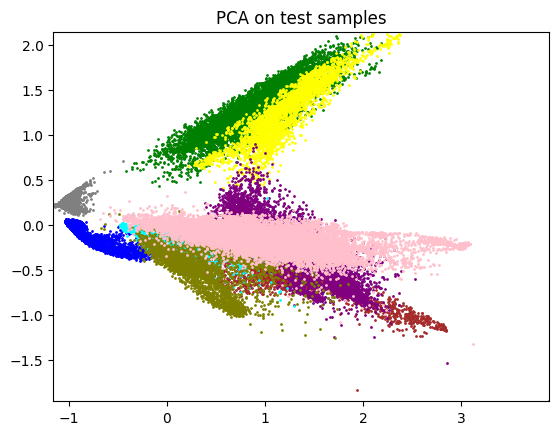

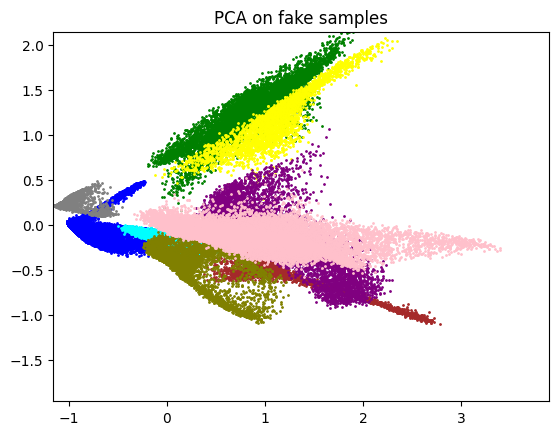

In [26]:
%matplotlib inline
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_test)
x_min, x_max = np.min(X_pca[:,0]), np.max(X_pca[:,0])
y_min, y_max = np.min(X_pca[:,1]), np.max(X_pca[:,1])

colors = ['red', 'blue', 'green', 'yellow', 'brown', 'purple', 'cyan', 'olive', 'pink', 'gray']
for i, color in enumerate(colors):
    idx = y_test == i
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], c=color, s=1)
    plt.ylim(y_min, y_max)
    plt.xlim(x_min, x_max)
    plt.title('PCA on test samples')
plt.show()

X_fake_pca = pca.transform(fake_X_test)
for i, color in enumerate(colors):
    idx = fake_y_test == i
    plt.scatter(X_fake_pca[idx, 0], X_fake_pca[idx, 1], s=1, c=color)
    plt.ylim(y_min, y_max)
    plt.xlim(x_min, x_max)
    plt.title('PCA on fake samples')
plt.show()

In [27]:
def train(net, X_train, y_train, epochs=100):
    dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train).float(),
                                             torch.from_numpy(y_train).long())
    loader = torch.utils.data.DataLoader(dataset, batch_size=1024, shuffle=True)
    solver = optim.Adam(net.parameters(), amsgrad=True)
    net.train()
    it = 0
    losses = []
    for _ in tqdm(range(epochs)):
        for X, y in loader:
            it += 1
            net.zero_grad()
            X, y = X.cuda(), y.cuda()
            out = net(X)
            loss = F.cross_entropy(out, y)
            loss.backward()
            solver.step()
            losses.append(loss.item())
            if it % 10000 == 0:
                print("Loss at {} = {}".format(it, loss.item()))
                plt.plot(losses) and plt.show()
    return net

  8%|██████▍                                                                      | 1249/15000 [03:01<32:04,  7.15it/s]

Loss at 10000 = 0.027936022728681564


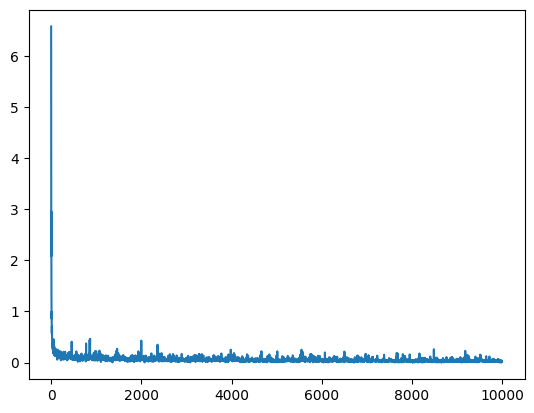

 17%|████████████▊                                                                | 2499/15000 [06:02<27:43,  7.52it/s]

Loss at 20000 = 0.04749077931046486


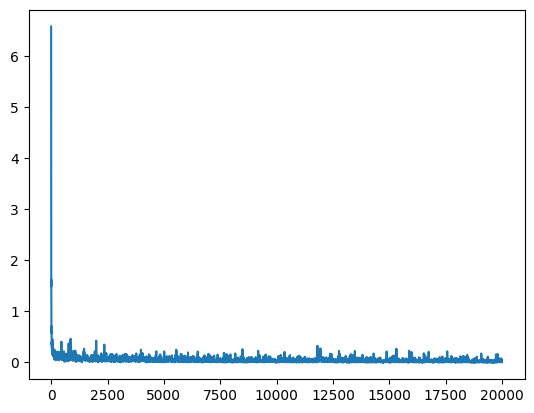

 25%|███████████████████▏                                                         | 3749/15000 [08:59<25:13,  7.44it/s]

Loss at 30000 = 0.0010592446196824312


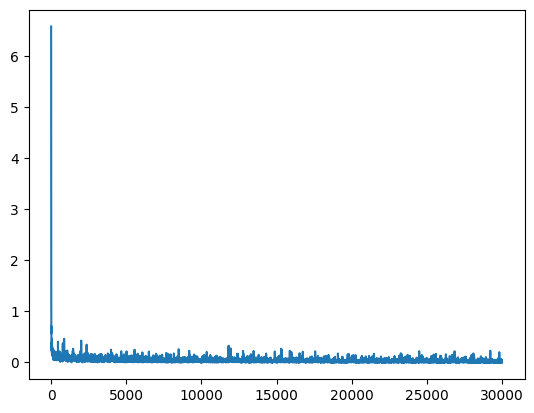

 33%|█████████████████████████▋                                                   | 4999/15000 [11:59<21:11,  7.86it/s]

Loss at 40000 = 0.006962638348340988


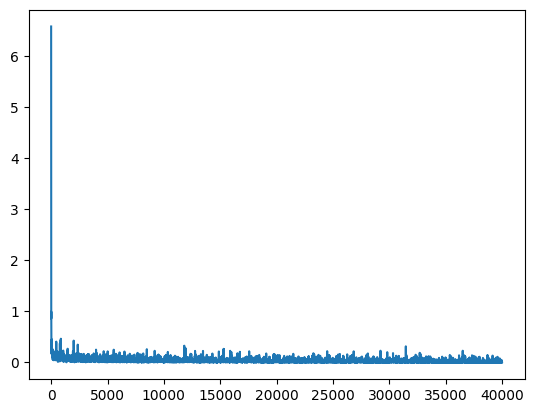

 42%|████████████████████████████████                                             | 6249/15000 [14:59<19:25,  7.51it/s]

Loss at 50000 = 0.0008774989983066916


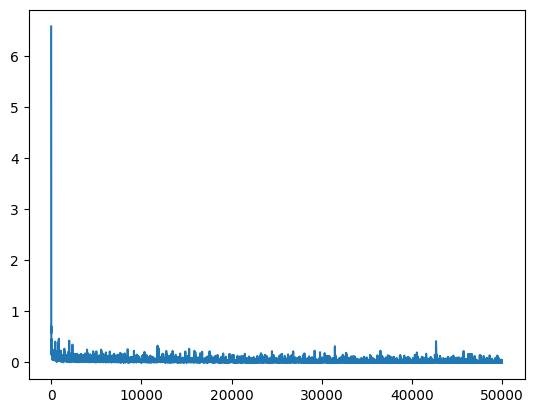

 50%|██████████████████████████████████████▍                                      | 7499/15000 [17:59<18:50,  6.64it/s]

Loss at 60000 = 0.00502926018089056


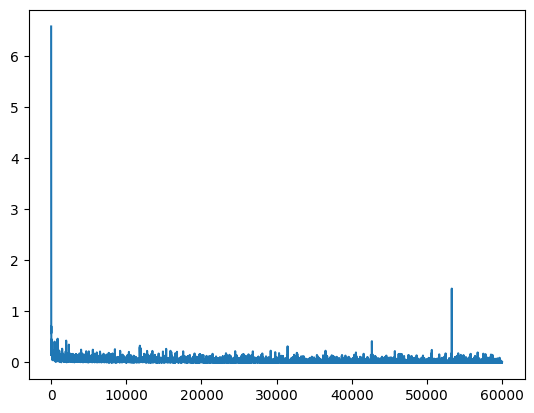

 58%|████████████████████████████████████████████▉                                | 8749/15000 [20:59<18:23,  5.66it/s]

Loss at 70000 = 0.006838802248239517


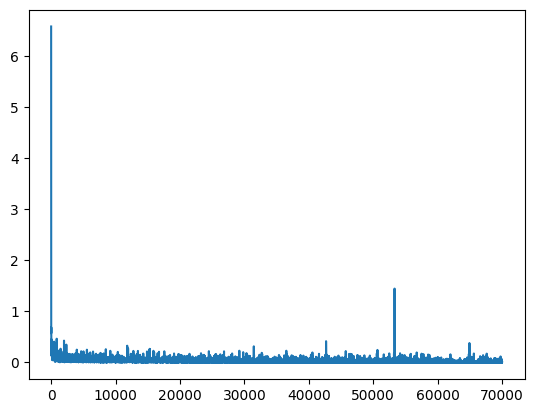

 67%|███████████████████████████████████████████████████▎                         | 9999/15000 [23:57<12:17,  6.78it/s]

Loss at 80000 = 0.0008311336860060692


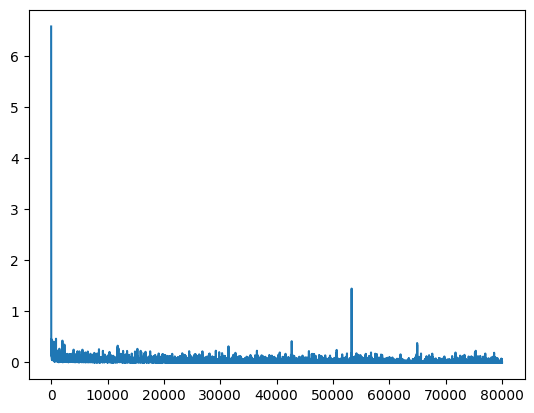

 75%|████████████████████████████████████████████████████████▉                   | 11249/15000 [27:00<08:19,  7.51it/s]

Loss at 90000 = 0.00021456324611790478


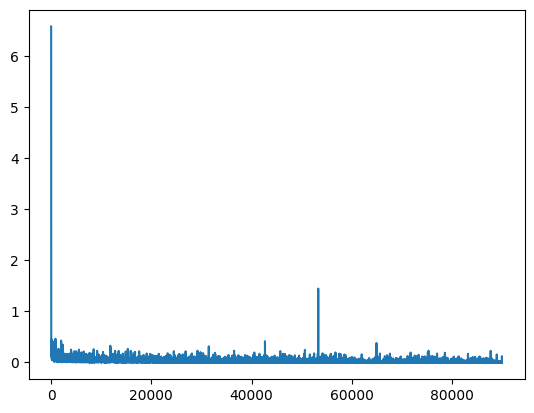

 83%|███████████████████████████████████████████████████████████████▎            | 12499/15000 [29:59<05:30,  7.57it/s]

Loss at 100000 = 0.00044235485256649554


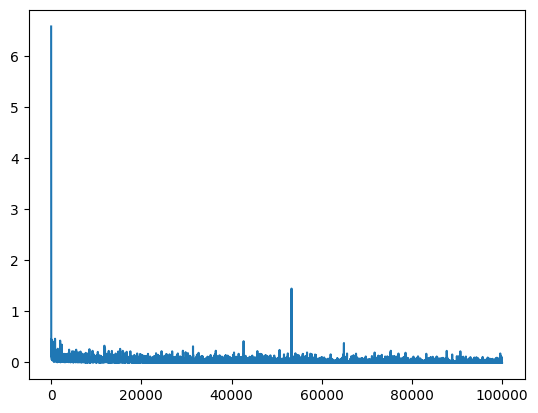

 92%|█████████████████████████████████████████████████████████████████████▋      | 13749/15000 [32:58<03:14,  6.42it/s]

Loss at 110000 = 0.00026060460368171334


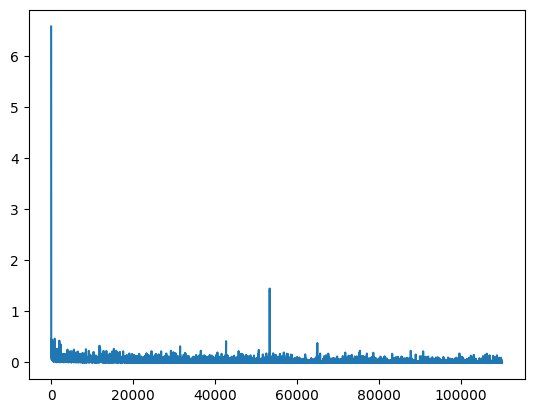

100%|███████████████████████████████████████████████████████████████████████████▉| 14999/15000 [36:00<00:00,  6.59it/s]

Loss at 120000 = 0.008637203834950924


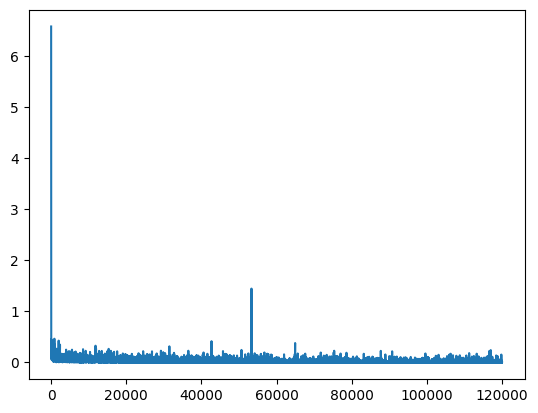

100%|████████████████████████████████████████████████████████████████████████████| 15000/15000 [36:01<00:00,  6.94it/s]


In [28]:
C_real = train(Classifier().cuda(), X_train, y_train, epochs=15000)

In [29]:
def test(net, X_test, y_test):
    with torch.no_grad():
        net.eval()
        print(X_test.shape)
        print(y_test.shape)
        dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test).float(),
                                                 torch.from_numpy(y_test).long())
        loader = torch.utils.data.DataLoader(dataset, batch_size=mb_size)
        pred = []
        for X, y in loader:
            X, y = X.cuda(), y.cuda()
            out = net(X)
            _, out = torch.max(out, 1)
            pred.append(out.cpu().numpy())
        pred = np.concatenate(pred)
        print(classification_report(y_test, pred, digits=4))
    return pred

In [30]:
test(C_real, X_test, y_test)

(140904, 102)
(140904,)
              precision    recall  f1-score   support

           1     0.9999    1.0000    1.0000     62815
           2     0.9795    0.9652    0.9723      7241
           3     0.9118    0.9422    0.9267      2939
           4     0.8610    0.8811    0.8709      2539
           5     0.9702    0.9702    0.9702      6250
           6     0.9720    0.9771    0.9745      8817
           7     0.9461    0.9428    0.9445      6892
           8     0.9983    0.9964    0.9973     40676
           9     0.9993    1.0000    0.9996      2735

    accuracy                         0.9883    140904
   macro avg     0.9598    0.9639    0.9618    140904
weighted avg     0.9884    0.9883    0.9883    140904



array([1, 1, 1, ..., 2, 2, 2], dtype=int64)

  4%|███▎                                                                        | 666/15000 [03:29<1:12:47,  3.28it/s]

Loss at 10000 = 0.011403322219848633


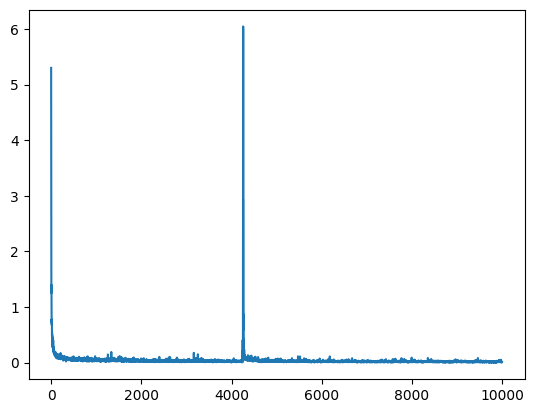

  9%|██████▋                                                                    | 1333/15000 [06:56<1:06:41,  3.42it/s]

Loss at 20000 = 0.009887397289276123


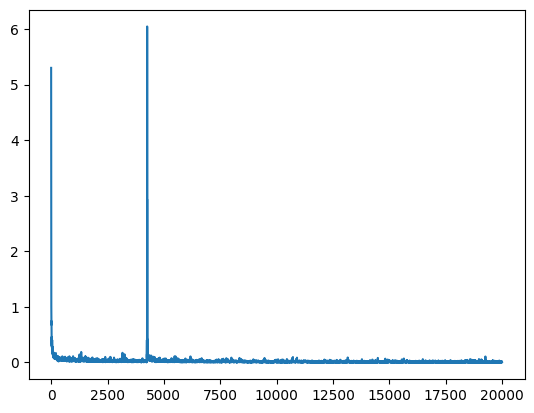

 13%|█████████▉                                                                 | 1999/15000 [10:21<1:10:17,  3.08it/s]

Loss at 30000 = 0.029738858342170715


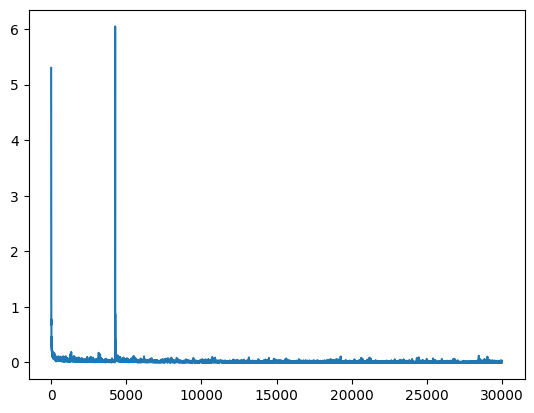

 18%|█████████████▎                                                             | 2666/15000 [13:45<1:08:02,  3.02it/s]

Loss at 40000 = 0.011893471702933311


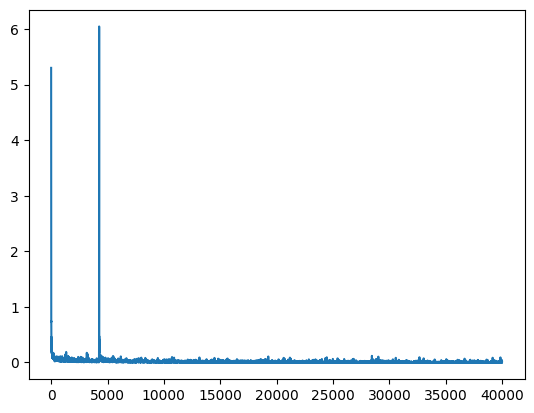

 22%|████████████████▋                                                          | 3333/15000 [17:07<1:00:20,  3.22it/s]

Loss at 50000 = 0.001447914750315249


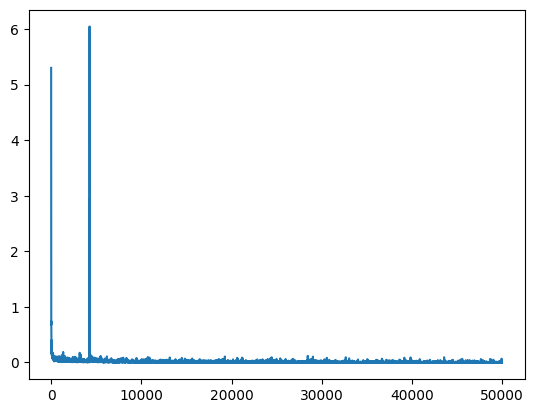

 27%|███████████████████▉                                                       | 3999/15000 [20:31<1:12:05,  2.54it/s]

Loss at 60000 = 0.00824520830065012


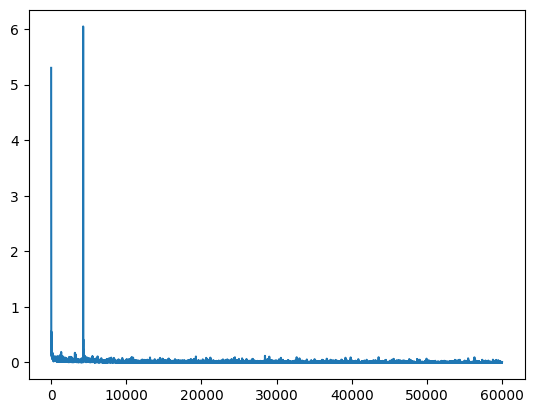

 31%|███████████████████████▉                                                     | 4666/15000 [23:57<51:31,  3.34it/s]

Loss at 70000 = 0.003919866867363453


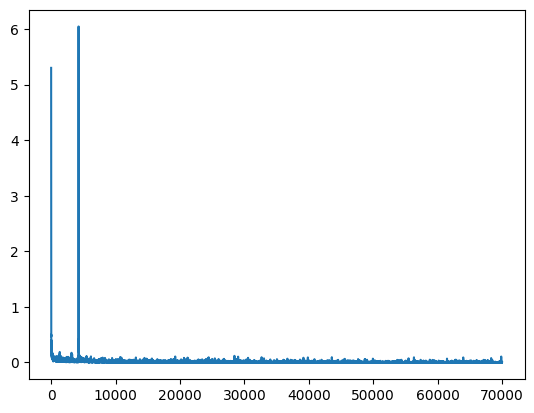

 36%|███████████████████████████▍                                                 | 5333/15000 [27:24<48:36,  3.31it/s]

Loss at 80000 = 0.0012922672322019935


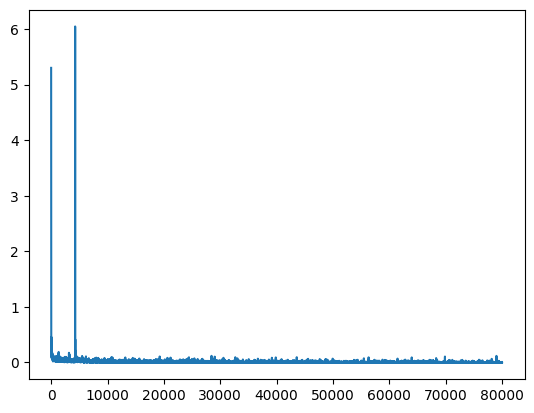

 40%|██████████████████████████████▊                                              | 5999/15000 [30:55<43:02,  3.49it/s]

Loss at 90000 = 1.506905937276315e-05


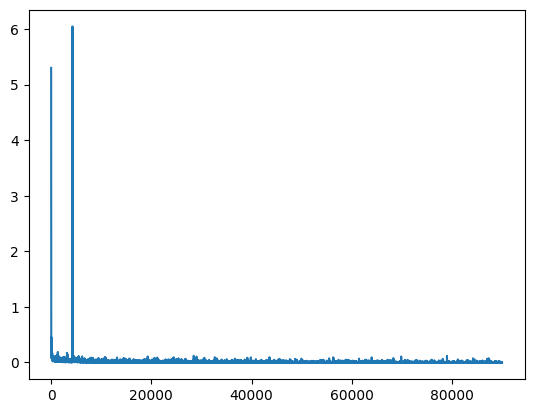

 44%|██████████████████████████████████▏                                          | 6666/15000 [34:22<39:42,  3.50it/s]

Loss at 100000 = 0.00037539147888310254


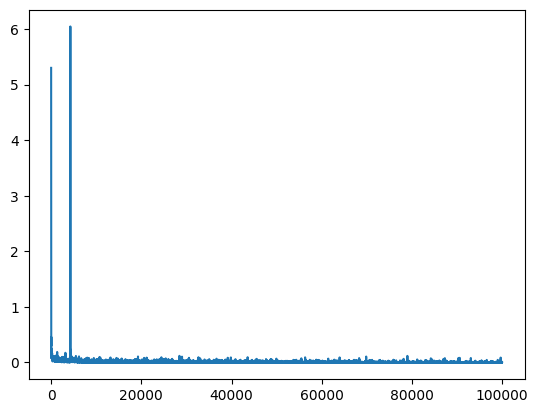

 49%|█████████████████████████████████████▋                                       | 7333/15000 [37:49<37:11,  3.44it/s]

Loss at 110000 = 0.0002355766191612929


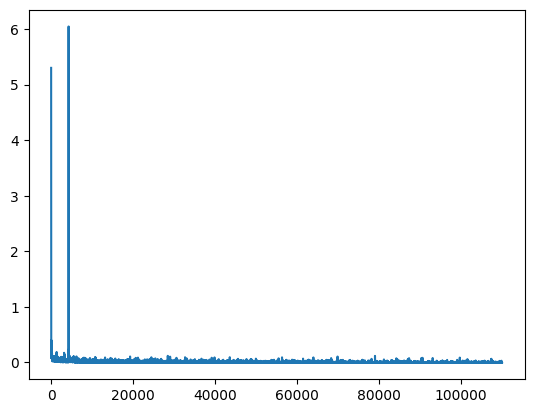

 53%|█████████████████████████████████████████                                    | 7999/15000 [41:13<37:09,  3.14it/s]

Loss at 120000 = 0.0015628872206434608


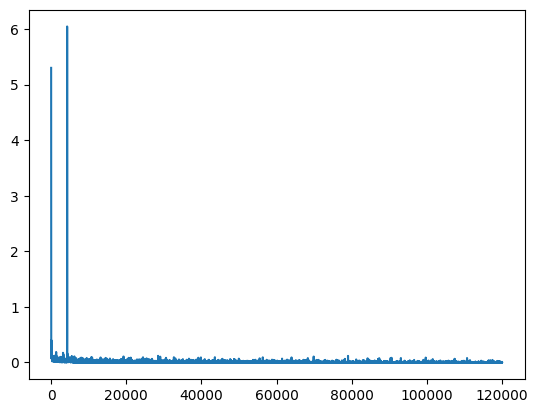

 58%|████████████████████████████████████████████▍                                | 8666/15000 [44:38<33:18,  3.17it/s]

Loss at 130000 = 8.330058335559443e-05


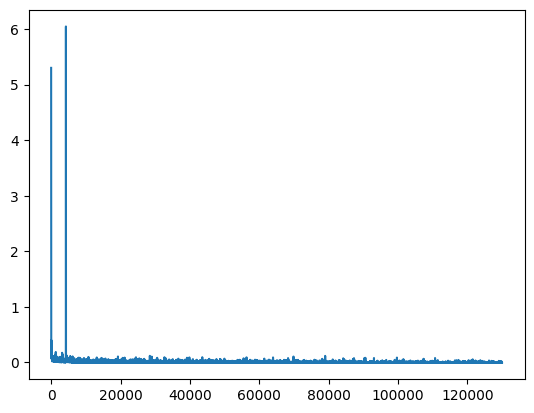

 62%|███████████████████████████████████████████████▉                             | 9333/15000 [48:02<30:56,  3.05it/s]

Loss at 140000 = 0.0006269117002375424


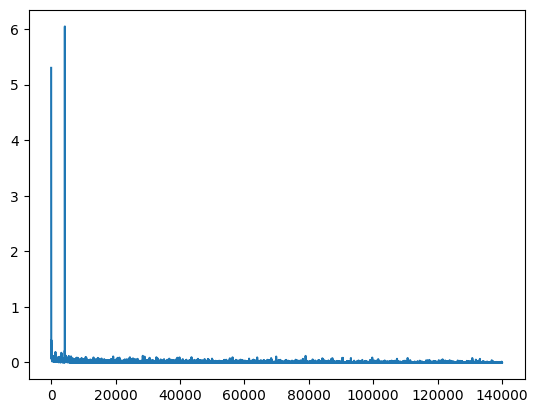

 67%|███████████████████████████████████████████████████▎                         | 9999/15000 [51:26<23:31,  3.54it/s]

Loss at 150000 = 4.525051735981833e-06


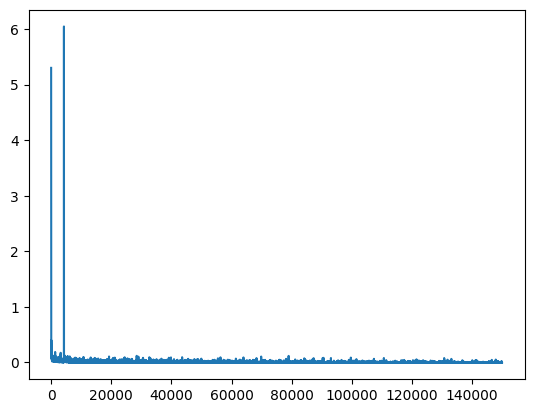

 71%|██████████████████████████████████████████████████████                      | 10666/15000 [54:50<22:17,  3.24it/s]

Loss at 160000 = 0.0019239757675677538


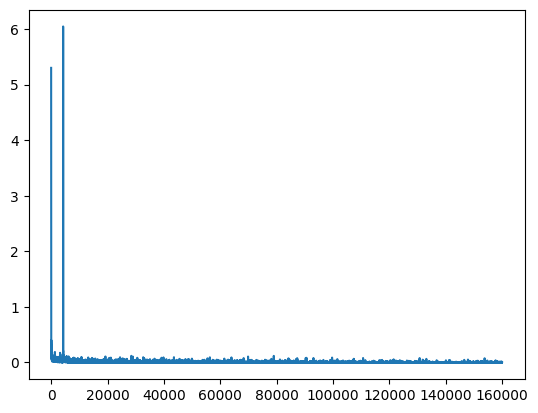

 76%|█████████████████████████████████████████████████████████▍                  | 11333/15000 [58:16<19:53,  3.07it/s]

Loss at 170000 = 4.9012680392479524e-05


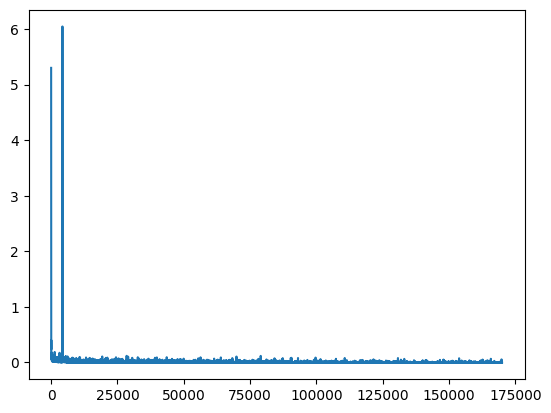

 80%|███████████████████████████████████████████████████████████▏              | 11999/15000 [1:01:39<14:49,  3.37it/s]

Loss at 180000 = 2.1605387701129075e-06


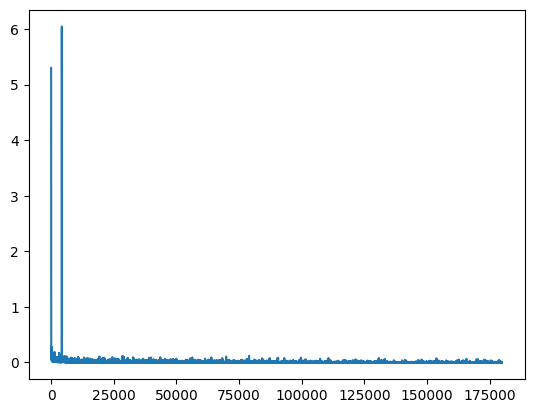

 84%|██████████████████████████████████████████████████████████████▍           | 12666/15000 [1:05:06<12:24,  3.13it/s]

Loss at 190000 = 5.094805237604305e-05


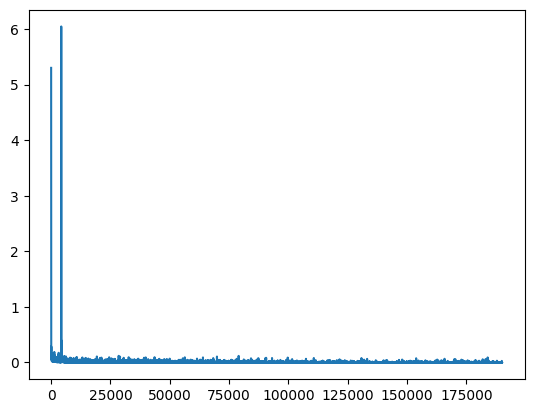

 89%|█████████████████████████████████████████████████████████████████▊        | 13333/15000 [1:08:33<08:06,  3.43it/s]

Loss at 200000 = 3.795010707108304e-05


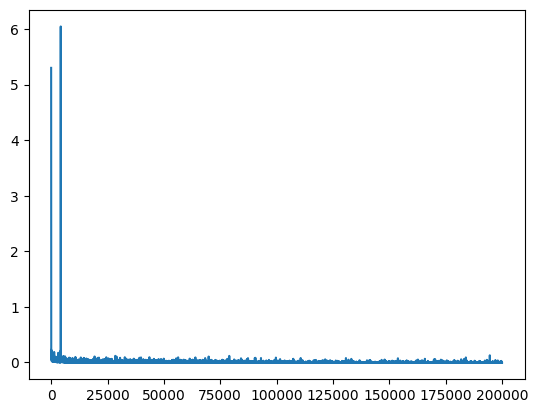

 93%|█████████████████████████████████████████████████████████████████████     | 13999/15000 [1:11:56<05:11,  3.22it/s]

Loss at 210000 = 5.603204408544116e-05


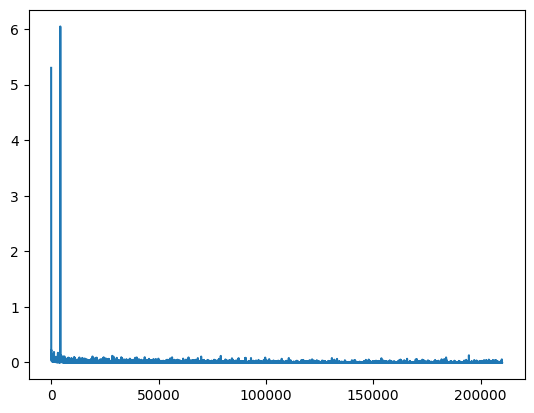

 98%|████████████████████████████████████████████████████████████████████████▎ | 14666/15000 [1:15:21<01:49,  3.05it/s]

Loss at 220000 = 0.00011612253001658246


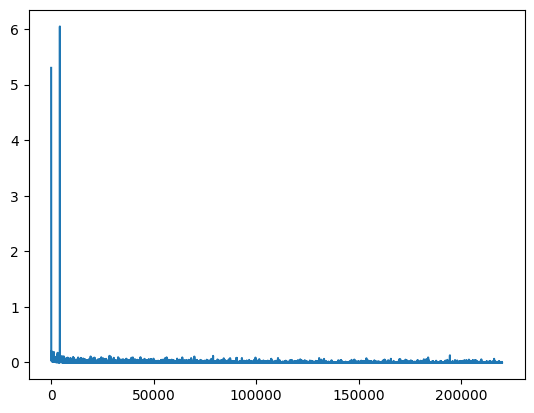

 98%|████████████████████████████████████████████████████████████████████████▍ | 14694/15000 [1:15:29<01:32,  3.29it/s]

In [ ]:
C_fake = train(Classifier().cuda(), np.concatenate((X_train, fake_X_train)), np.concatenate((y_train, fake_y_train)), epochs=15000)

In [ ]:
test(C_fake, X_test, y_test)